## Import Libraries

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


## Import Sales Data

In [76]:
df = pd.read_csv('Case2_Sales data.csv', sep=';')

In [77]:
df.head()

DATE Mapped_GCK Sales_EUR
0  01.10.2018         #1         0
1  02.10.2018         #1         0
2  03.10.2018         #1         0
3  04.10.2018         #1         0
4  05.10.2018         #1         0

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DATE        9802 non-null   object
 1   Mapped_GCK  9802 non-null   object
 2   Sales_EUR   9802 non-null   object
dtypes: object(3)
memory usage: 229.9+ KB


In [79]:
# Verifying that there are no duplicated records
df.duplicated().sum()

0

# Correct data types

- Convert `Date` to dd-mm-yyyy
- Convert `Sales_EUR` to float

In [80]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%d.%m.%Y')
df['Sales_EUR'] = df['Sales_EUR'].str.replace(',','.')
df['Sales_EUR']=df['Sales_EUR'].astype('float64')

# Handle Sales
Delete Sales when `Sales_EUR` == 0, because it means no sale actually

In [81]:
df.drop(df[df['Sales_EUR'] == 0].index, inplace=True)

In [82]:
len(df)

2668

Remove `#` before `Mapped_GCK` and convert it into an int in order to better sort the values 

In [83]:
df['Mapped_GCK']=df['Mapped_GCK'].str.replace('#', '')
df['Mapped_GCK']=df['Mapped_GCK'].astype('int16')

Convert date just to year and month since we will agreggate the sales by month and year

In [84]:
df['DATE'] = df['DATE'].dt.strftime('%Y-%m')

In [85]:
# verifying that the applied function works
# df[(df['DATE'] == '2018-10') & (df['Mapped_GCK'] == 1)].value_counts()

**Aggregating sales by the same month and year according to each `Mapped_GCK` <br>**
- Create a new feature to count the number of occurences for the same `Mapped_GCK` in the same month and year: `Counts` <br>
- Create a new feature to sum the sales amount for the same `Mapped_GCK` in the same month and year: `Total_Sales_EUR`

In [86]:
df = df.groupby(['DATE', 'Mapped_GCK']).agg({'DATE': 'count', 'Sales_EUR': 'sum'}).rename(columns={'DATE': 'Counts', 'Sales_EUR': 'Total_Sales_€'}).reset_index()

In [87]:
df.head()

DATE  Mapped_GCK  Counts  Total_Sales_€
0  2018-10           1       3    36098918.79
1  2018-10           3       4     8089465.96
2  2018-10           4       3      397760.69
3  2018-10           5       3     2499061.19
4  2018-10           6       3      369231.60

In [88]:
len(df)

592

Check unique products

In [89]:
print('Unique products:', list(df['Mapped_GCK'].unique()))
print('Number of different products:',len(df['Mapped_GCK'].unique()))

Unique products: [1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 20, 36]
Number of different products: 14


Check the min and max Date <br>

In [90]:
print("Earliest date:", df['DATE'].min())
print("Most recent date:", df['DATE'].max())

Earliest date: 2018-10
Most recent date: 2022-04


In [91]:
df['DATE'] = pd.to_datetime(df['DATE'])

# Data Exploration/ Visualization

## Sales throughout the time

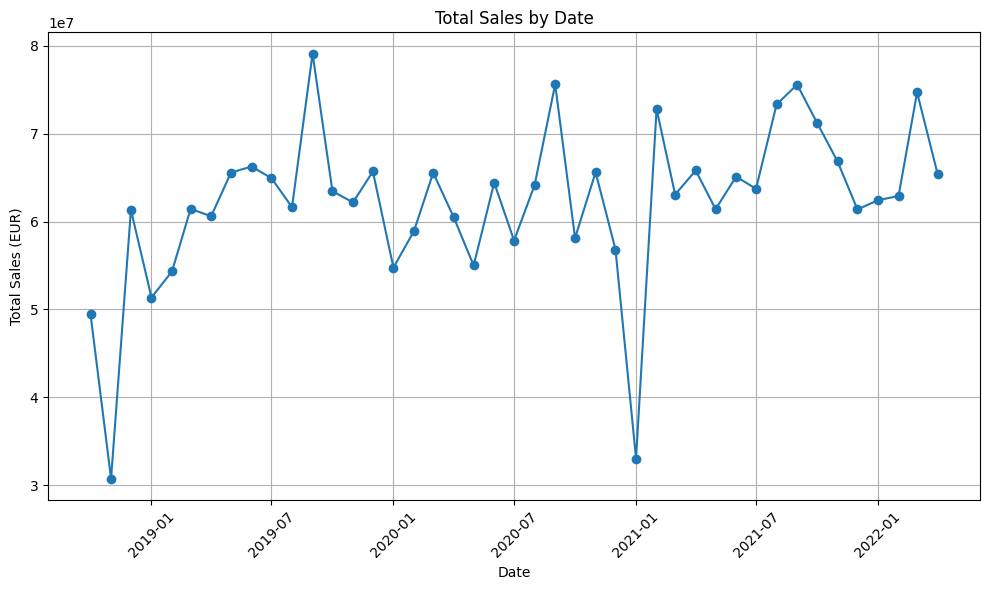

In [92]:
sales_by_date = df.groupby('DATE')['Total_Sales_€'].sum()

# Plot the total sales by date
plt.figure(figsize=(10, 6))
plt.plot(sales_by_date.index, sales_by_date.values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Total Sales (EUR)')
plt.title('Total Sales by Date')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

## Sales by quarters

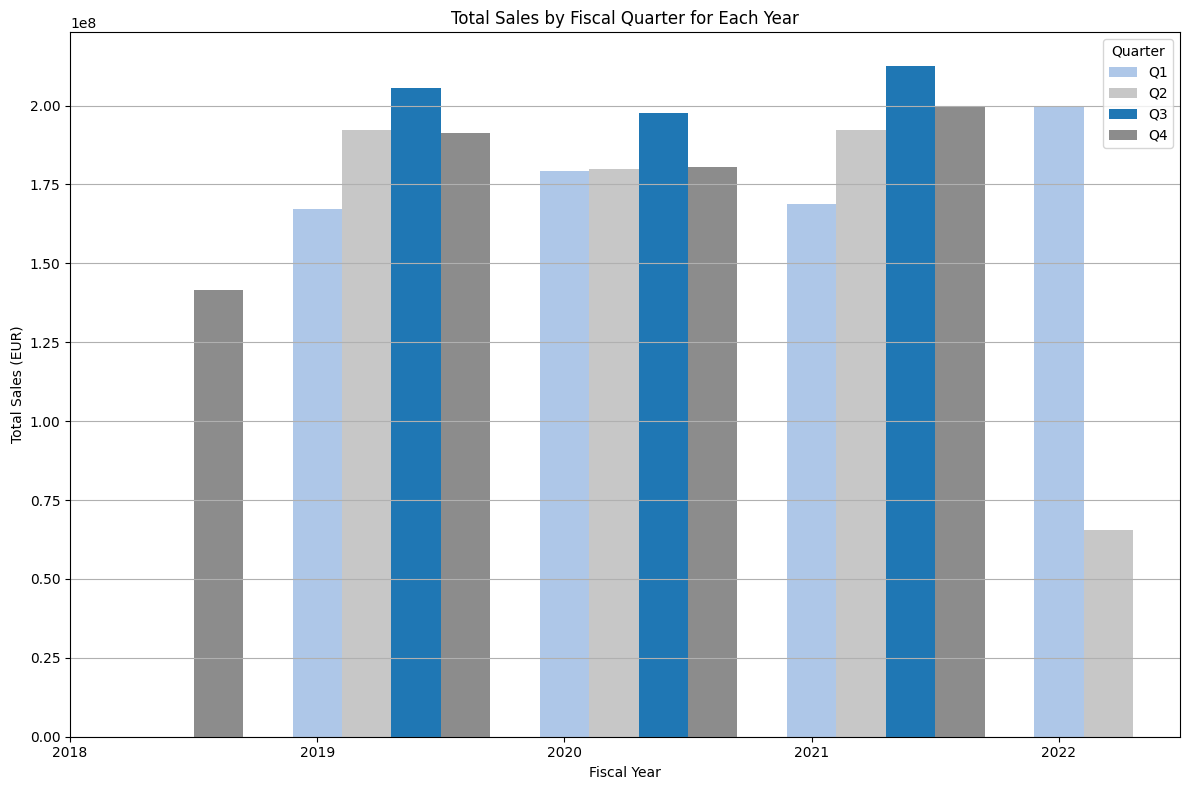

In [93]:
# Group by 'Date' and 'Year', summing 'Sales_EUR' for each quarter and year
sales_by_quarter_year = df.groupby([df['DATE'].dt.year, df['DATE'].dt.quarter])['Total_Sales_€'].sum().unstack()

# Plot the sales by quarter for each year
plt.figure(figsize=(12, 8))

quarters = ['Q1', 'Q2', 'Q3', 'Q4']
colors = ['#aec7e8', '#c7c7c7','#1f77b4', '#8c8c8c']

for i, quarter in enumerate(quarters):
    sales_data = sales_by_quarter_year[i + 1]  # Quarter index starts from 1
    x = range(len(sales_data))
    plt.bar([pos + i*0.2 for pos in x], sales_data.values, width=0.2, color=colors[i], label=quarter)

plt.xlabel('Fiscal Year')
plt.ylabel('Total Sales (EUR)')
plt.title('Total Sales by Fiscal Quarter for Each Year')
plt.xticks(range(len(sales_data)), sales_data.index)
plt.legend(title='Quarter', loc='upper right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Total Sales for each Mapped_GCK (all the time)

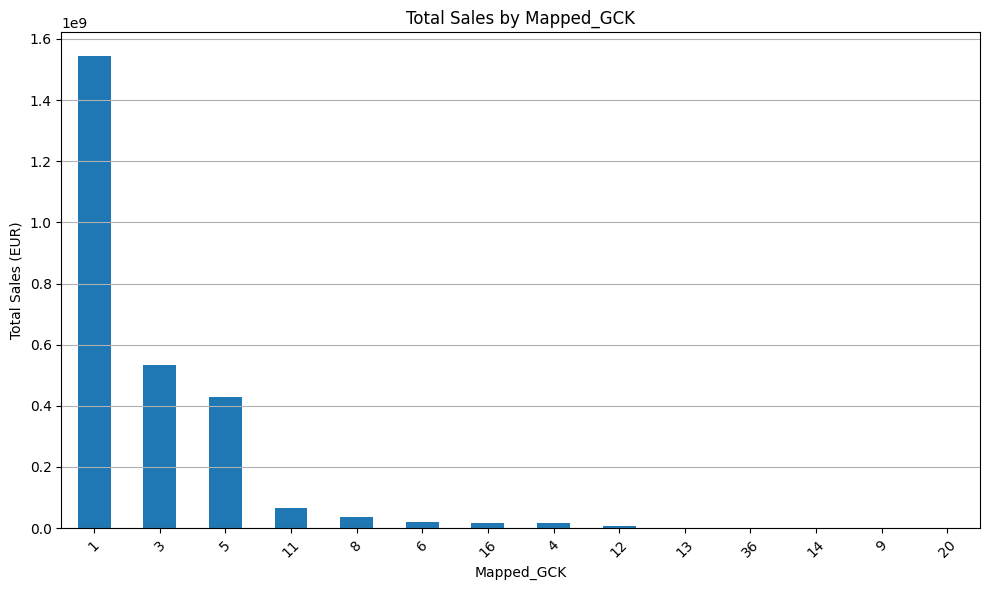

In [94]:
sales_by_mapped_gck = (df.groupby('Mapped_GCK')['Total_Sales_€'].sum()).sort_values(ascending=False)

# Plot the total sales for each 'Mapped_GCK'
plt.figure(figsize=(10, 6))
sales_by_mapped_gck.plot(kind='bar')
plt.xlabel('Mapped_GCK')
plt.ylabel('Total Sales (EUR)')
plt.title('Total Sales by Mapped_GCK')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')
plt.tight_layout()
plt.show()

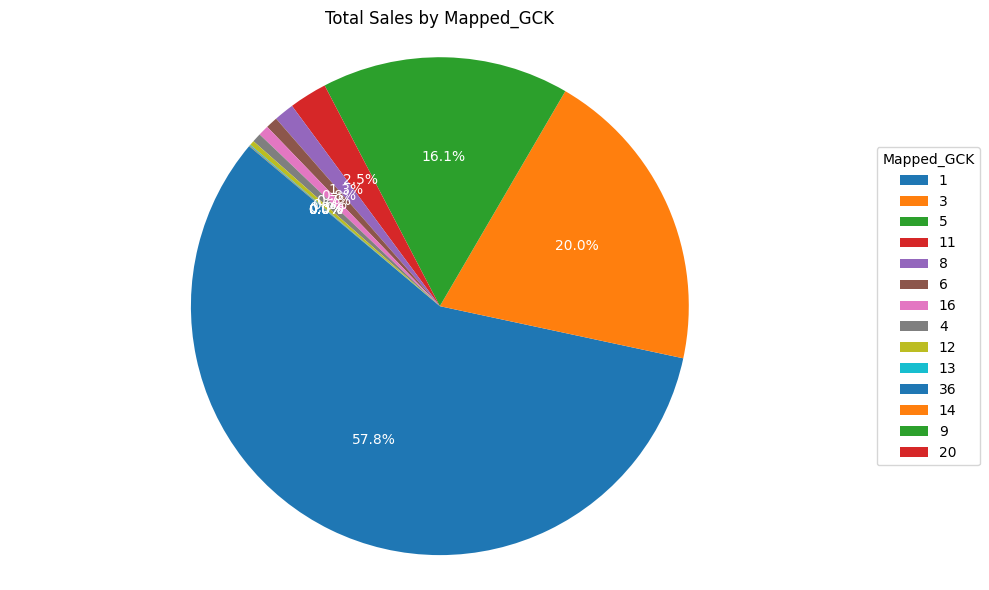

In [95]:
# Plot the total sales for each 'Mapped_GCK' as a pie chart
plt.figure(figsize=(10, 6))
patches, texts, autotexts = plt.pie(sales_by_mapped_gck, autopct='%1.1f%%', startangle=140)

# Improve legibility of autopct labels on the pie chart
for text in autotexts:
    text.set_color('white')

plt.title('Total Sales by Mapped_GCK')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.

# Place a legend on the side
plt.legend(patches, sales_by_mapped_gck.index, title='Mapped_GCK', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()  # Adjust the plot to ensure everything fits without overlap
plt.show()

`Mapped_GCK` == 1 is by far the product with the highest amount of sales over the years

## Sales for each Mapped_GCK for each year

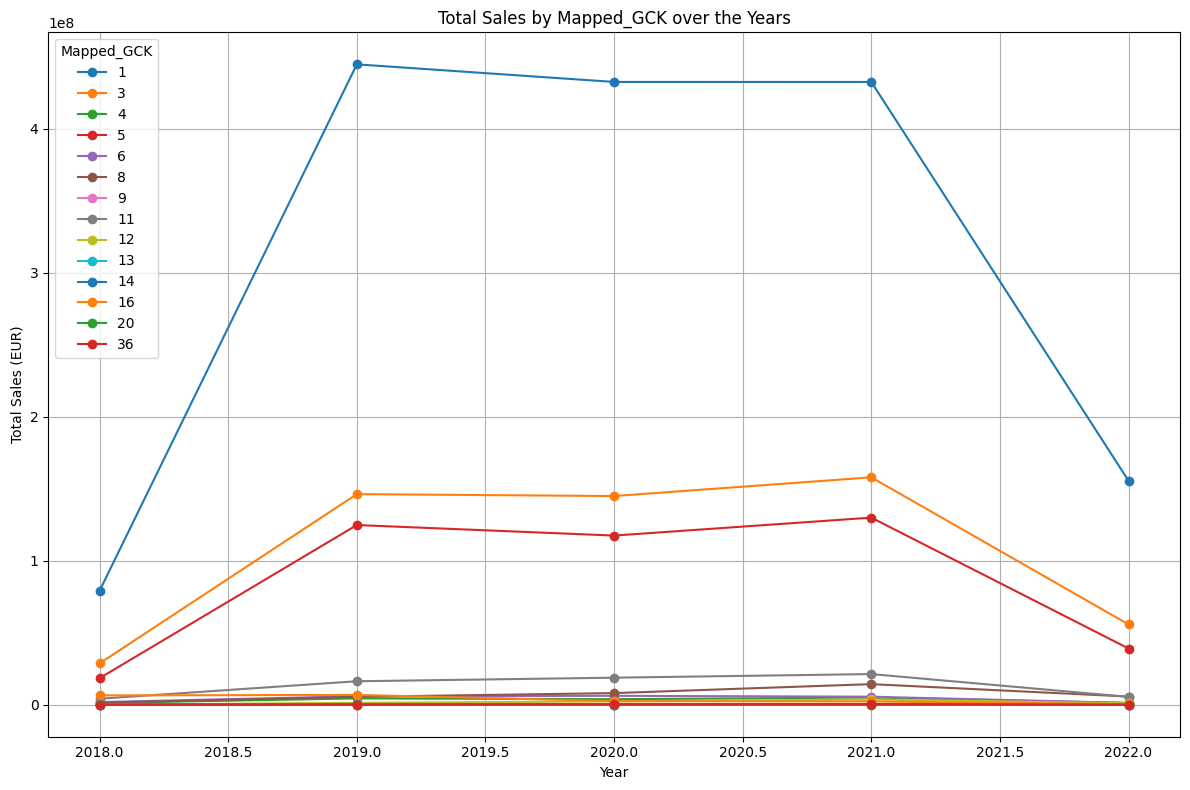

In [96]:
# Group by 'Mapped_GCK' and extract year from 'DATE', sum 'Sales_EUR' for each group
sales_by_mapped_gck_year = df.groupby([df['DATE'].dt.year, 'Mapped_GCK'])['Total_Sales_€'].sum()


# Plot the total sales for each 'Mapped_GCK' over the years
plt.figure(figsize=(12, 8))

# Iterate over each 'Mapped_GCK' group
for mapped_gck, sales_data in sales_by_mapped_gck_year.groupby(level=1):
    years = sales_data.index.get_level_values(0).astype(int)
    plt.plot(sales_data.index.get_level_values(0), sales_data.values, label=mapped_gck,  marker='o', linestyle='-')

plt.xlabel('Year')
plt.ylabel('Total Sales (EUR)')
plt.title('Total Sales by Mapped_GCK over the Years')
plt.legend(title='Mapped_GCK', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Product 1 consistently leads in sales across the years, with Products 3 and 5 being the second and third top-selling products, respectively.

## Sales for each Mapped_GCK throughout the months for each year

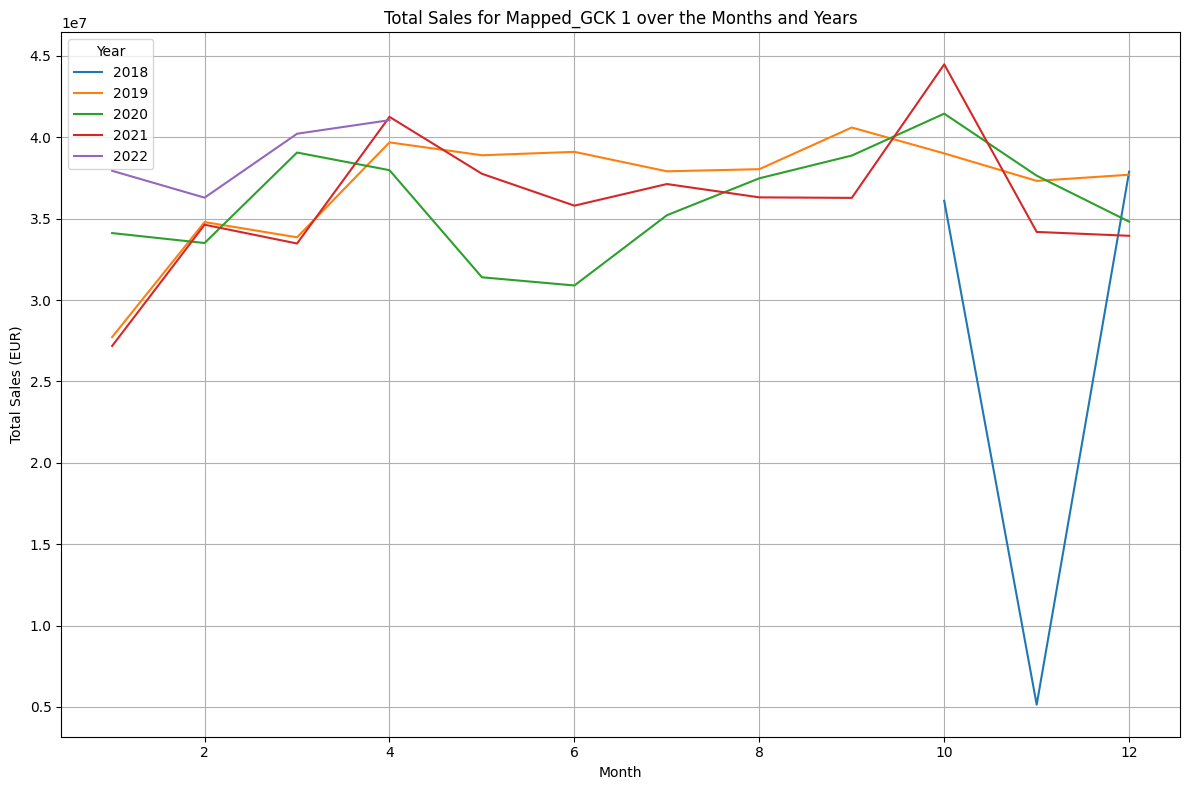

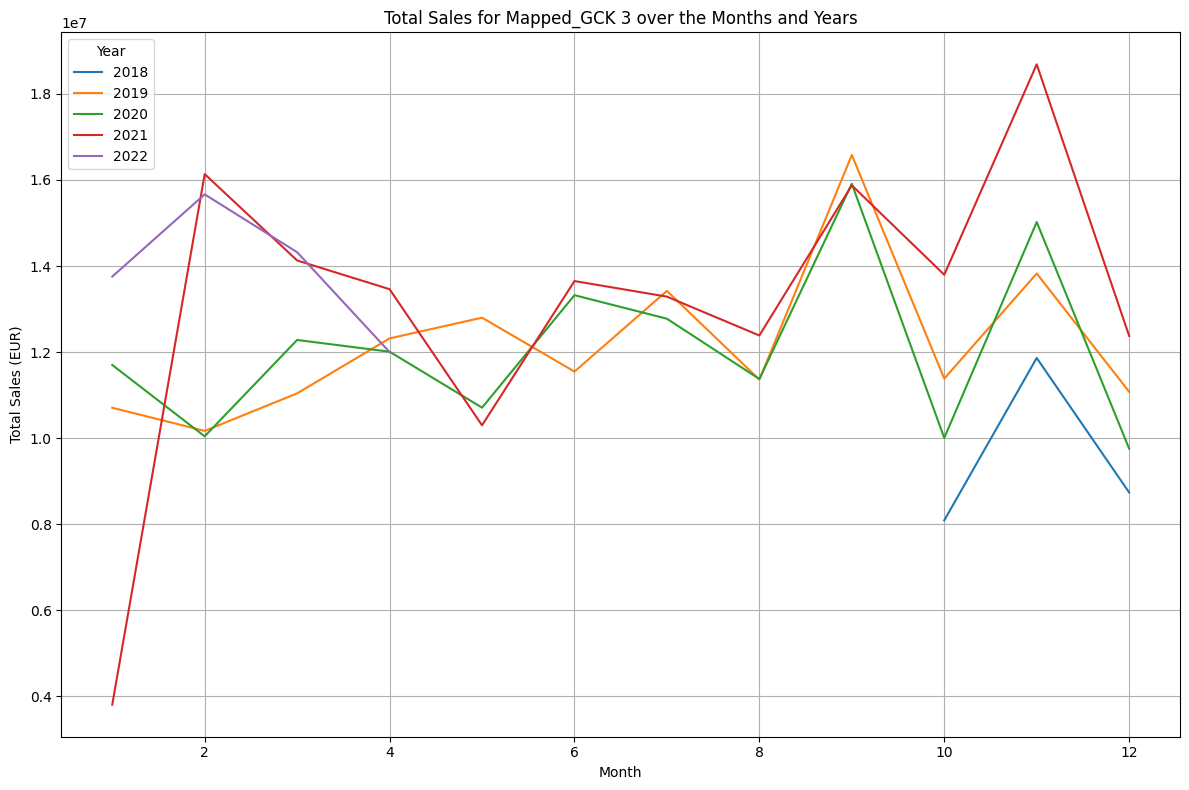

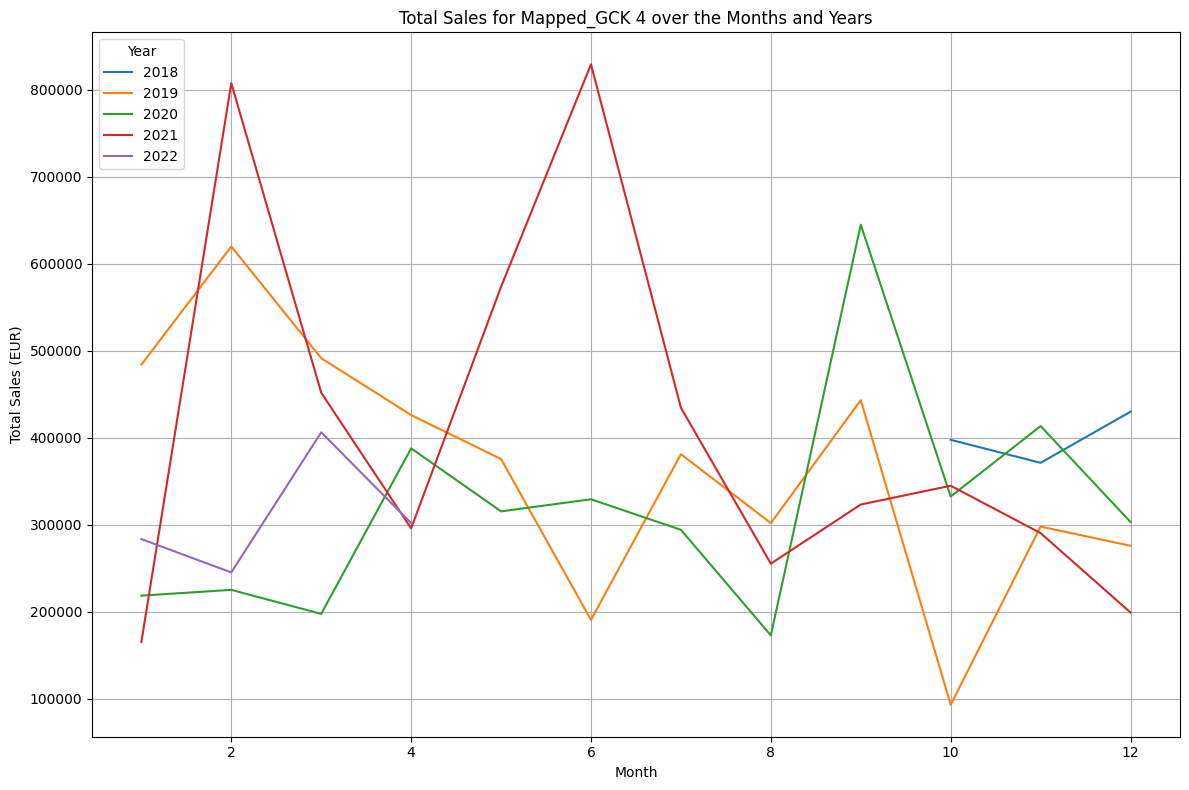

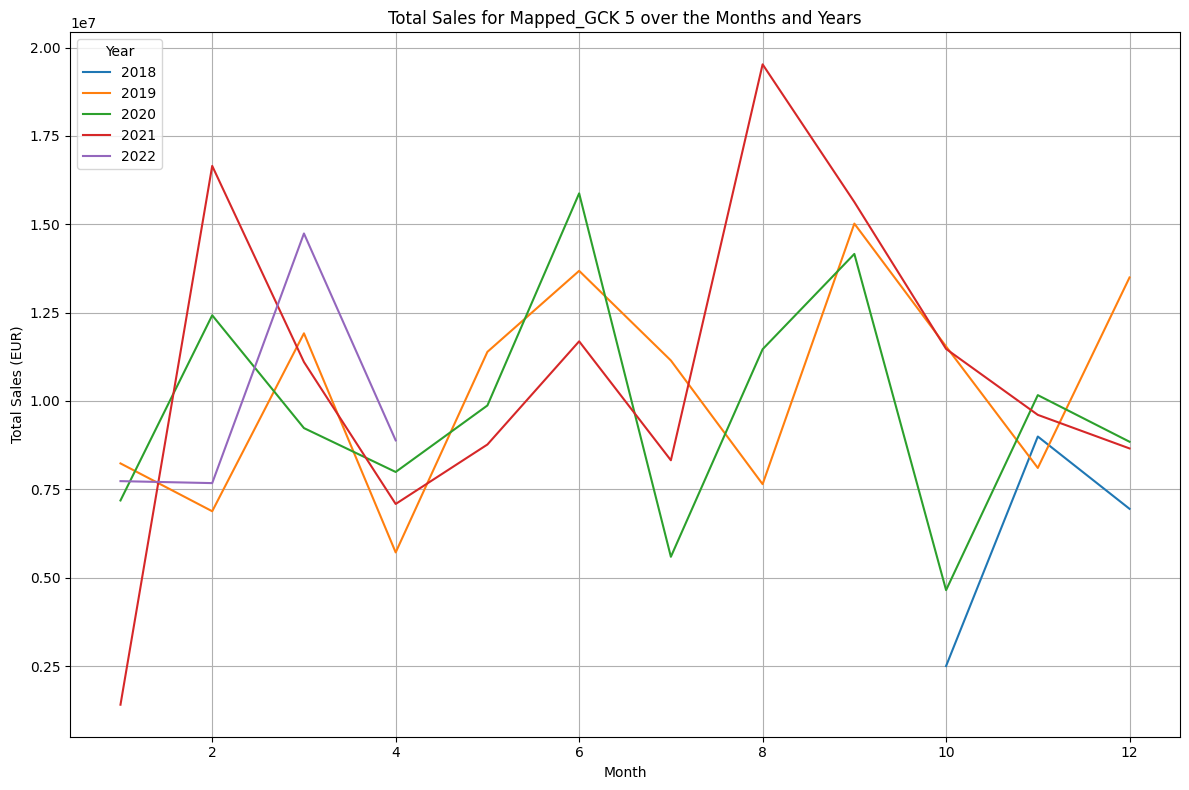

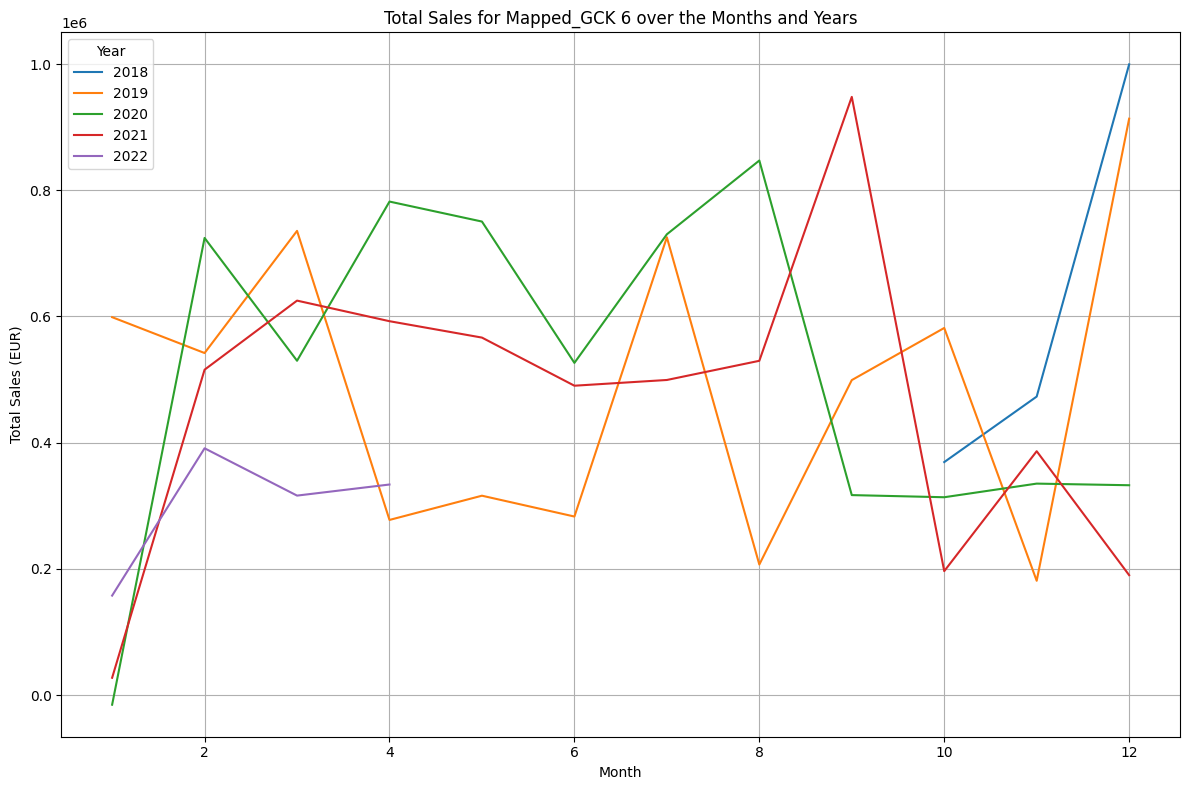

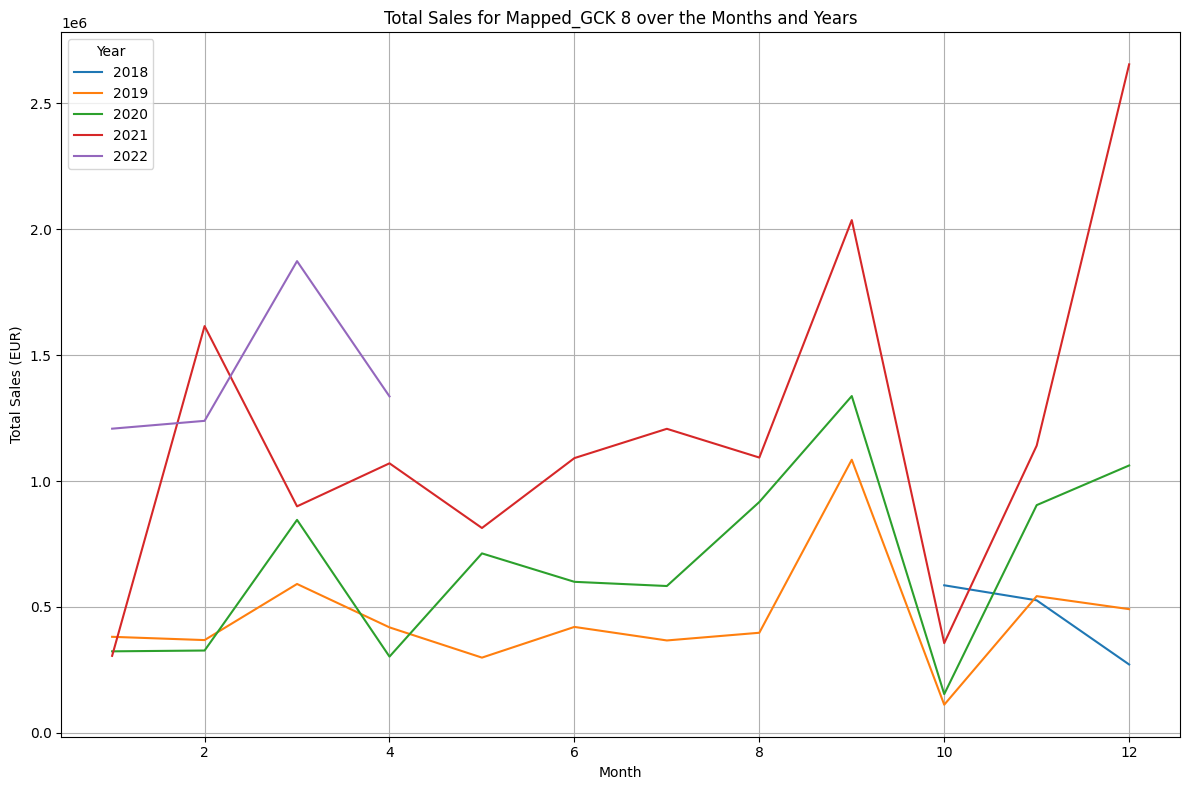

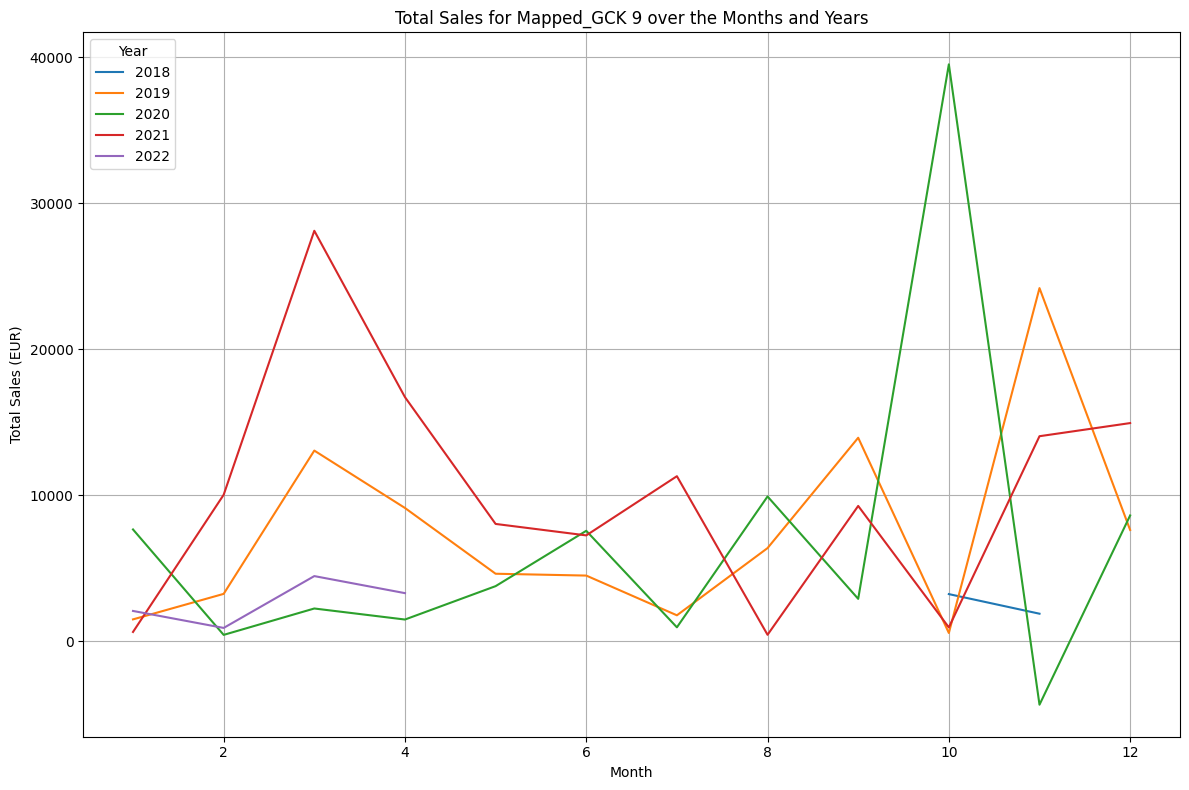

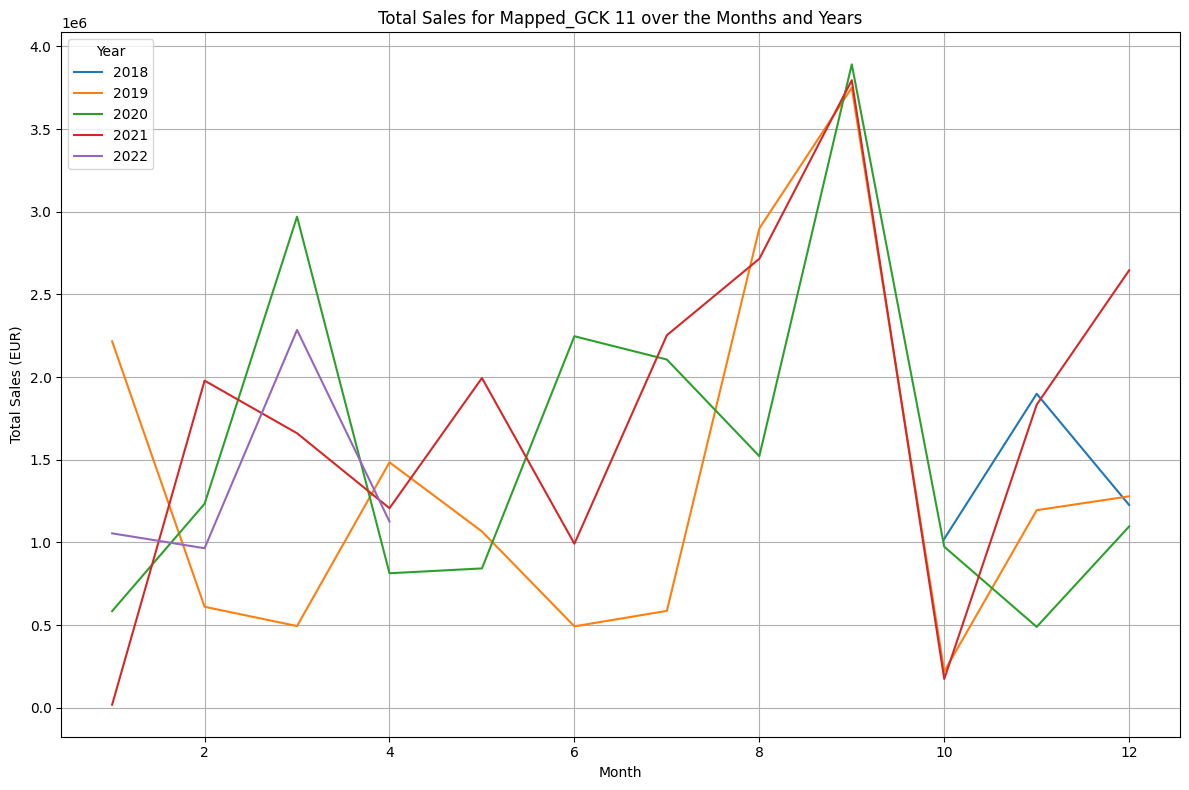

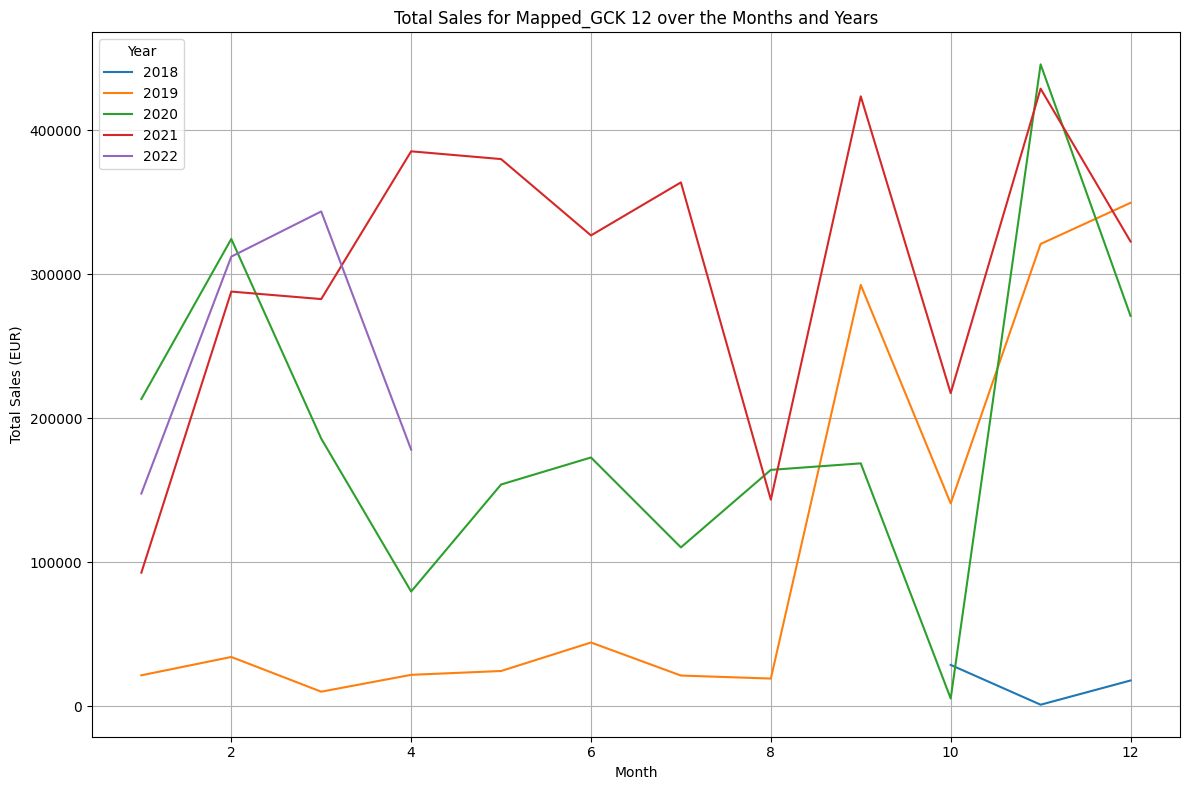

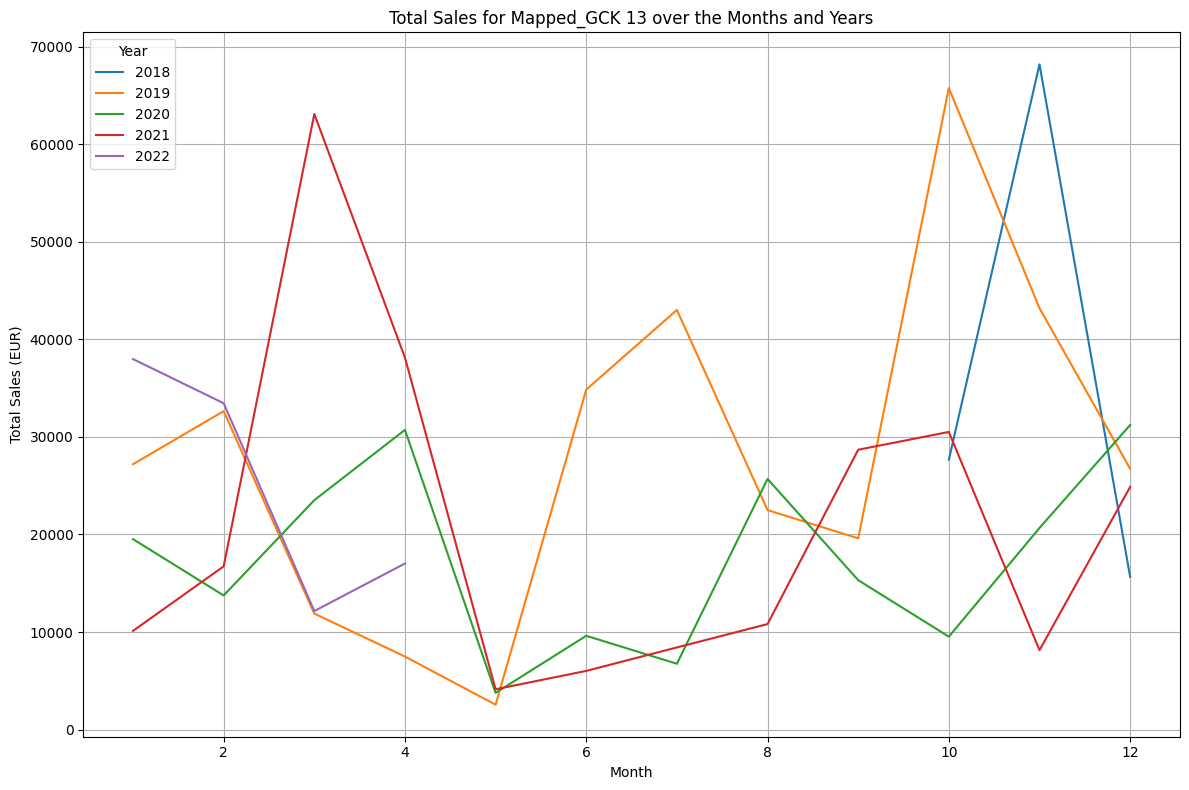

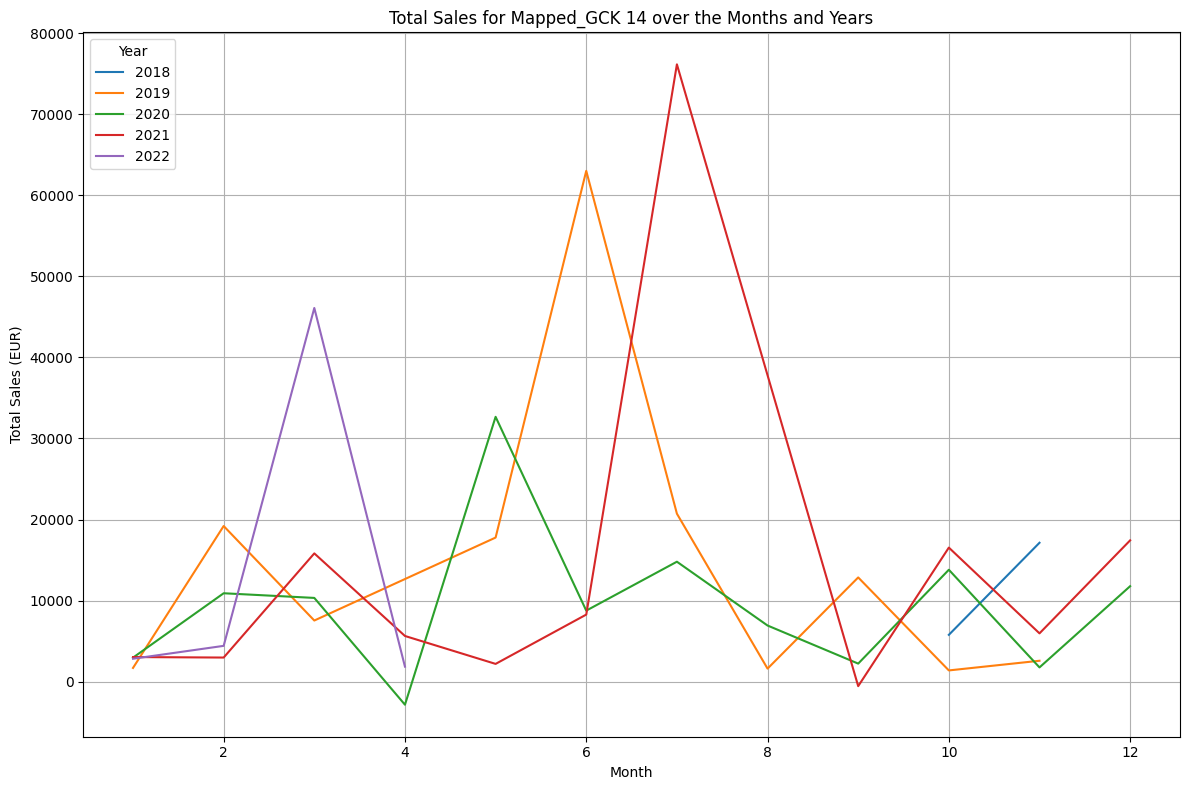

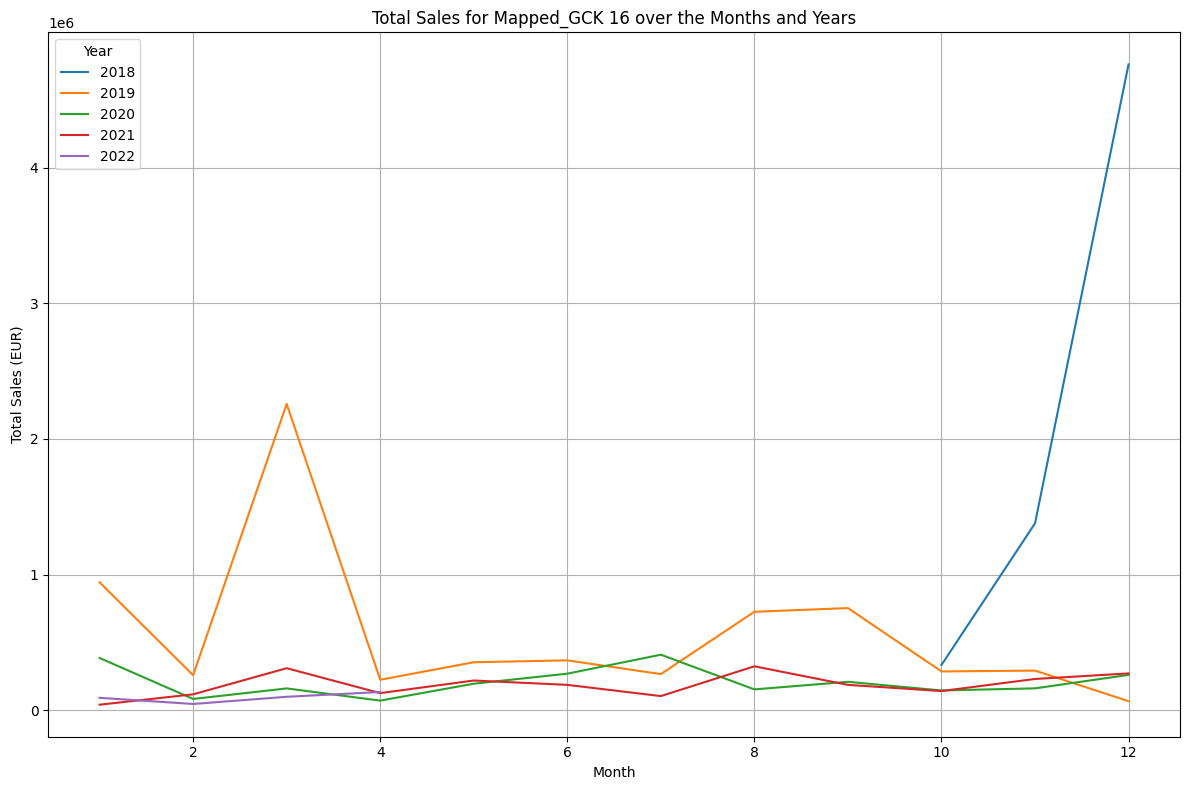

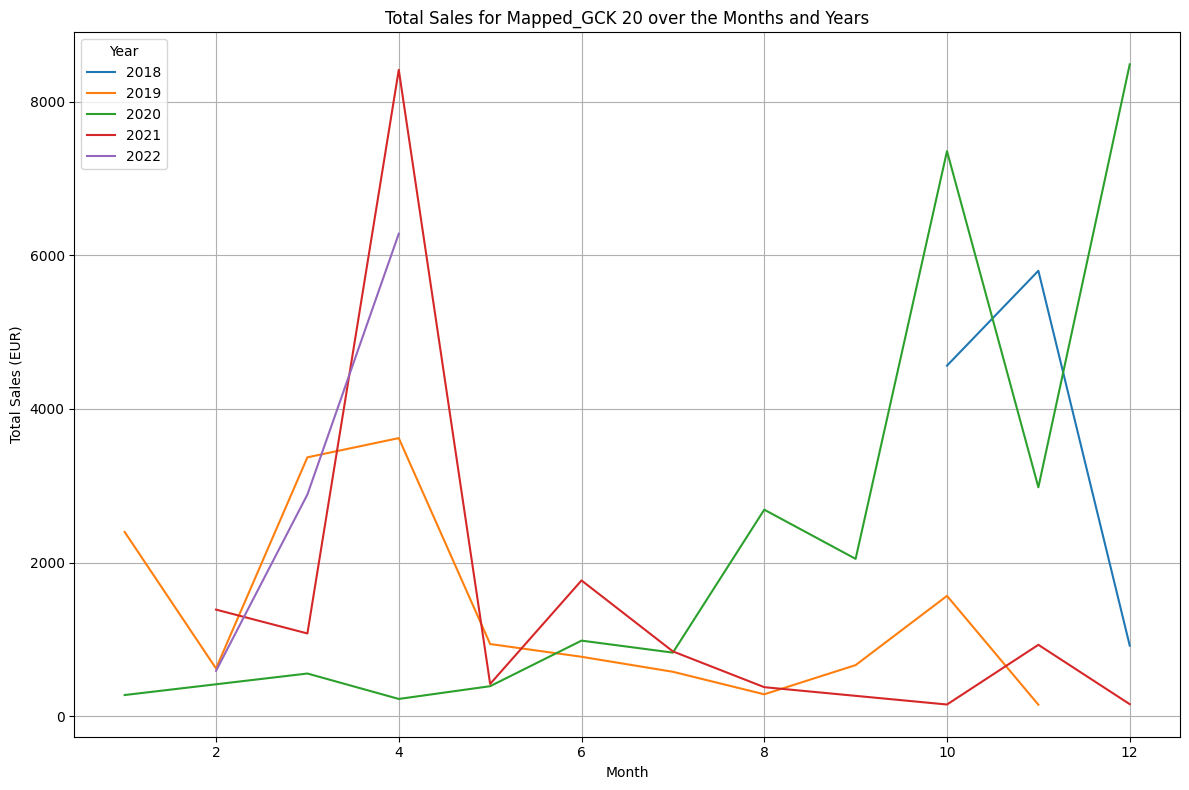

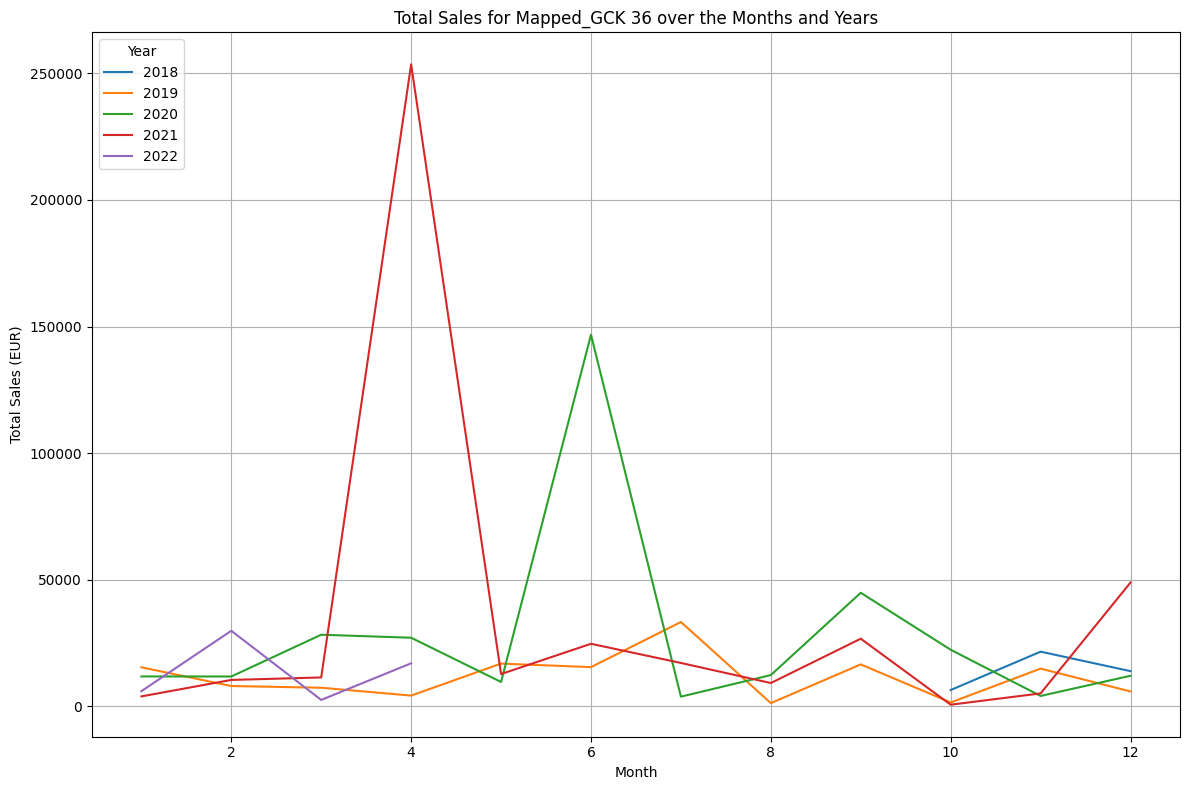

In [97]:
# Group by 'Mapped_GCK', 'Year', and 'Month', sum 'Sales_EUR' for each group
sales_by_mapped_gck_year_month = df.groupby([df['DATE'].dt.year, df['DATE'].dt.month, 'Mapped_GCK'])['Total_Sales_€'].sum()

# Get unique Mapped_GCK values
unique_mapped_gck = df['Mapped_GCK'].unique()

# Plot the sales for each 'Mapped_GCK' over the months for each year
for mapped_gck in unique_mapped_gck:
    plt.figure(figsize=(12, 8))
    
    # Filter sales data for current Mapped_GCK
    sales_data = sales_by_mapped_gck_year_month.loc[:, :, mapped_gck]
    
    # Iterate over each year within the group
    for year, sales_year_data in sales_data.groupby(level=0):
        plt.plot(sales_year_data.index.get_level_values(1), sales_year_data.values, label=f'{year}')

    plt.xlabel('Month')
    plt.ylabel('Total Sales (EUR)')
    plt.title(f'Total Sales for Mapped_GCK {mapped_gck} over the Months and Years')
    plt.legend(title='Year', loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Total Sales for each Mapped_GCK grouped by quarters

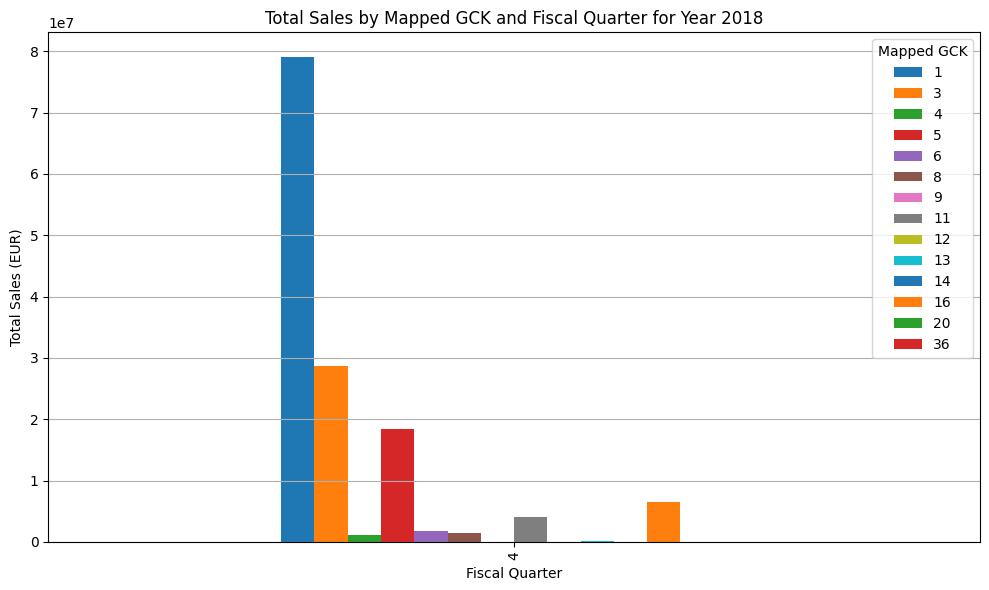

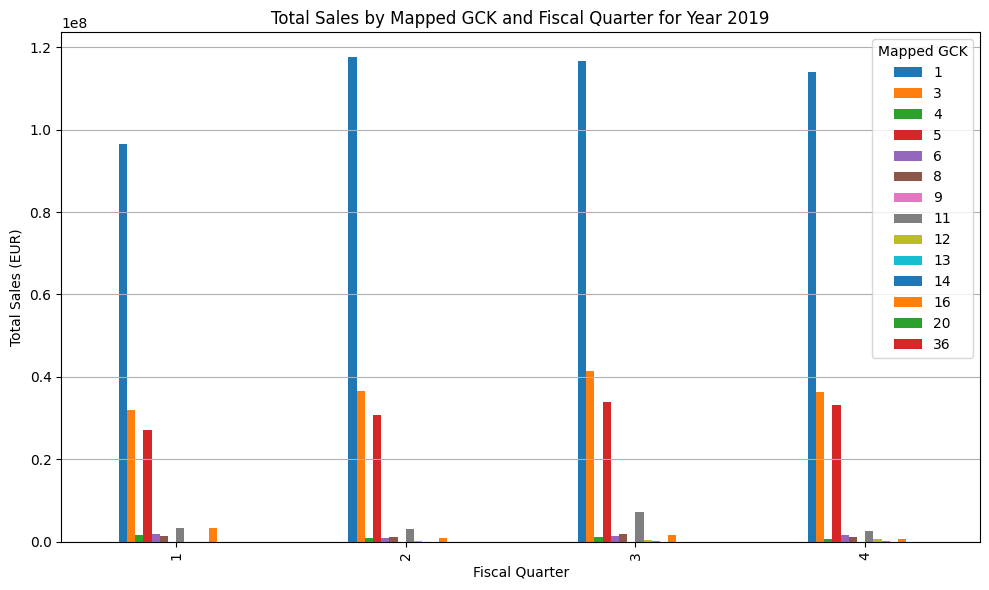

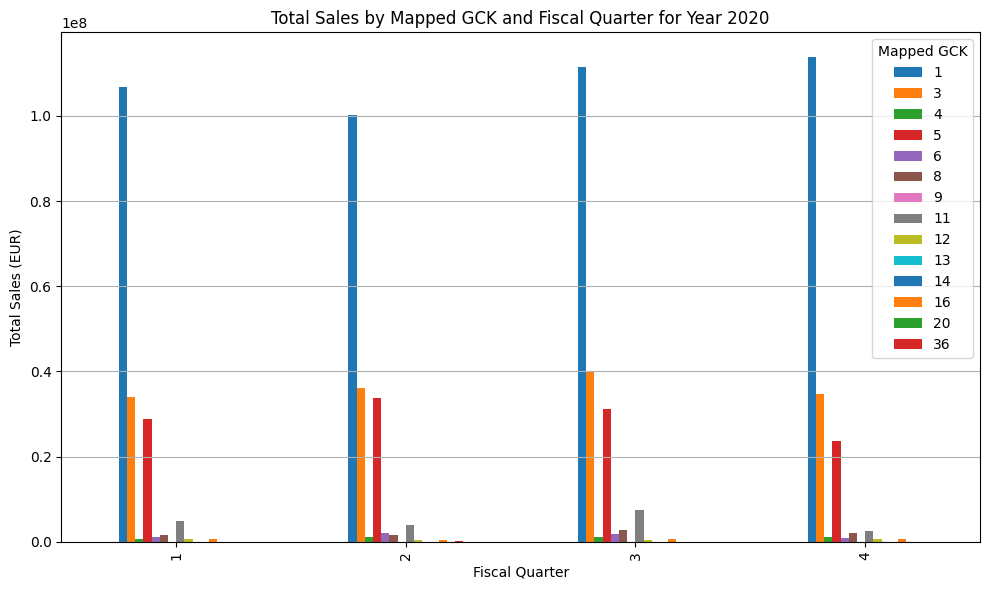

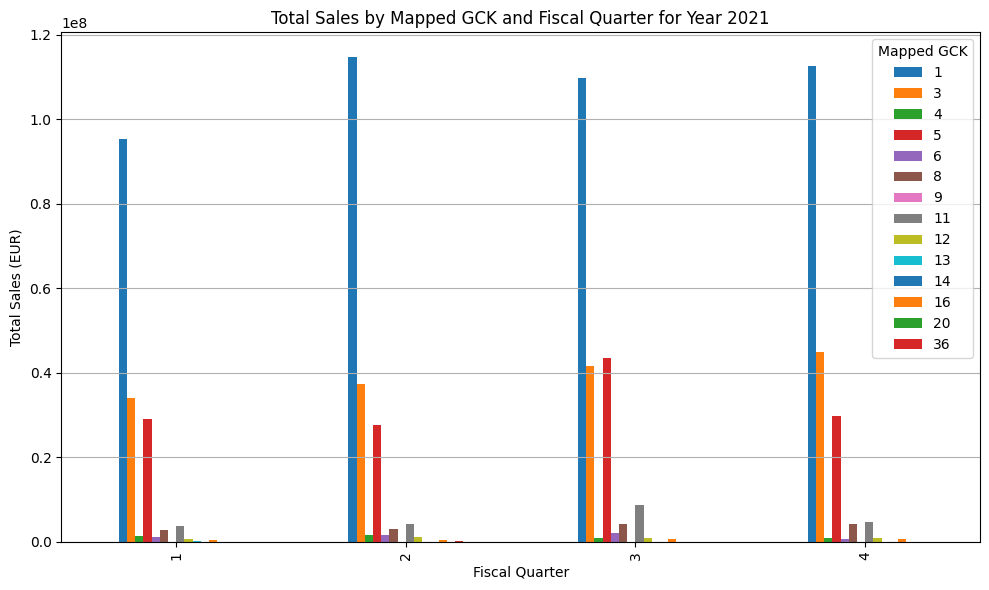

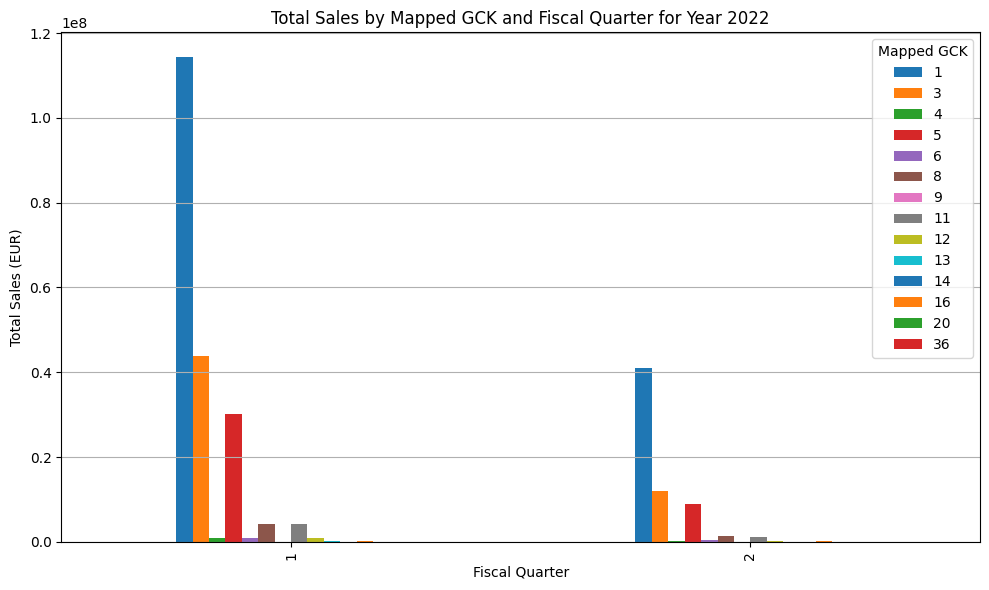

In [98]:
# Get unique years from the 'Fiscal_Date' column
unique_years = df['DATE'].dt.year.unique()

# Iterate over unique years
for year in unique_years:
    # Filter the DataFrame for the current year
    df_year = df[df['DATE'].dt.year == year]
    
    # Group by 'Fiscal_Quarter' and 'mapped_gck', and sum the sales
    sales_by_quarter_and_gck = df_year.groupby([df['DATE'].dt.quarter, 'Mapped_GCK'])['Total_Sales_€'].sum().unstack()
    
    # Plot the sales for each mapped_gck by quarters for the current year
    sales_by_quarter_and_gck.plot(kind='bar', figsize=(10, 6))
    plt.xlabel('Fiscal Quarter')
    plt.ylabel('Total Sales (EUR)')
    plt.title(f'Total Sales by Mapped GCK and Fiscal Quarter for Year {year}')
    plt.legend(title='Mapped GCK', bbox_to_anchor=(1, 1))
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


- Product 1 dominates sales across all quarters, maintaining its position as the top performer
- Products 3 and 5 have similar sales amounts, although significantly lower than Product 1, with each contributing approximately 1/3 the sales compared to Product 1.
- There are no seasonal products

# Feature Engineering

In [99]:
df.head()

DATE  Mapped_GCK  Counts  Total_Sales_€
0 2018-10-01           1       3    36098918.79
1 2018-10-01           3       4     8089465.96
2 2018-10-01           4       3      397760.69
3 2018-10-01           5       3     2499061.19
4 2018-10-01           6       3      369231.60

In [100]:
df_feat_eng = df.copy()

## Import Consumer Price Index 
- In order to achieve a better prediction, we will consider inflation throughout the time
- Consumer price index is based on 2020 (2020 = 100)

In [101]:
df_cpi = pd.read_excel('Consumer_Prices.xlsx')
df_cpi.head()

Year    Month   Consumer Price
0  2018   January            96.4
1  2018  February            96.7
2  2018     March            97.2
3  2018     April            97.5
4  2018       May            98.2

In [102]:
df_cpi.rename(columns={'Month ': 'Month'}, inplace=True)

### Sales_CPI
Adjusting sales for inflation involves multiplying the sales by the consumer price index (CPI) for each month. By doing so, we obtain real sales that reflect the actual value of sales, considering the effects of inflation. This adjustment allows for more accurate comparisons of sales performance over time.

In [103]:
# Create a'Date' column using the 'Year' and 'Month' columns
df_cpi['Date'] = pd.to_datetime(df_cpi['Year'].astype(str) + '-' + df_cpi['Month'] + '-01')
 
# drop the 'Year' and 'Month' columns
df_cpi = df_cpi.drop(columns=['Year', 'Month'])
# Reorder columns
df_cpi = df_cpi.reindex(columns=['Date', 'Consumer Price'])
 
df_cpi.head()

Date  Consumer Price
0 2018-01-01            96.4
1 2018-02-01            96.7
2 2018-03-01            97.2
3 2018-04-01            97.5
4 2018-05-01            98.2

In [104]:
df_cpi['Date'] = pd.to_datetime(df_cpi['Date'])

In [105]:
# merge the two data frames on the "Date" column
# df_cpi['Date']=df_cpi['Date'].dt.strftime('%Y-%m')
df_feat_eng = pd.merge(df_feat_eng, df_cpi, left_on='DATE', right_on='Date', how='left')
df_feat_eng

DATE  Mapped_GCK  Counts  Total_Sales_€       Date  Consumer Price
0   2018-10-01           1       3    36098918.79 2018-10-01            99.1
1   2018-10-01           3       4     8089465.96 2018-10-01            99.1
2   2018-10-01           4       3      397760.69 2018-10-01            99.1
3   2018-10-01           5       3     2499061.19 2018-10-01            99.1
4   2018-10-01           6       3      369231.60 2018-10-01            99.1
..         ...         ...     ...            ...        ...             ...
587 2022-04-01          13       4       17020.04 2022-04-01           108.8
588 2022-04-01          14       3        1846.20 2022-04-01           108.8
589 2022-04-01          16       9      134071.24 2022-04-01           108.8
590 2022-04-01          20       3        6280.63 2022-04-01           108.8
591 2022-04-01          36       3       17029.47 2022-04-01           108.8

[592 rows x 6 columns]

In [106]:
df_feat_eng['Sales_CPI_€'] = df_feat_eng['Total_Sales_€'] * df_feat_eng['Consumer Price'].astype(float)/100
df_feat_eng.drop('Total_Sales_€',inplace=True, axis=1)
df_feat_eng.drop('Date',inplace=True, axis=1)
df_feat_eng.drop('Consumer Price',inplace=True, axis=1)
df_feat_eng

DATE  Mapped_GCK  Counts   Sales_CPI_€
0   2018-10-01           1       3  3.577403e+07
1   2018-10-01           3       4  8.016661e+06
2   2018-10-01           4       3  3.941808e+05
3   2018-10-01           5       3  2.476570e+06
4   2018-10-01           6       3  3.659085e+05
..         ...         ...     ...           ...
587 2022-04-01          13       4  1.851780e+04
588 2022-04-01          14       3  2.008666e+03
589 2022-04-01          16       9  1.458695e+05
590 2022-04-01          20       3  6.833325e+03
591 2022-04-01          36       3  1.852806e+04

[592 rows x 4 columns]

#### Sales CPI per month for each GCK

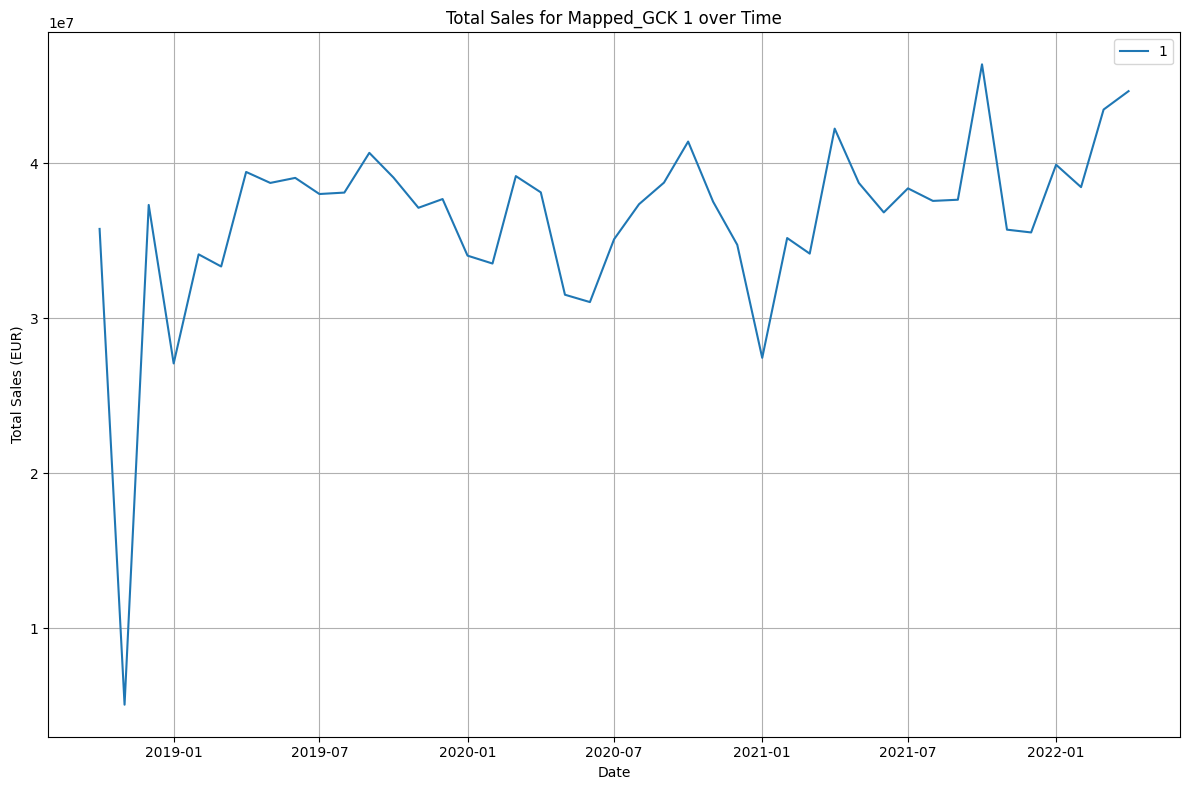

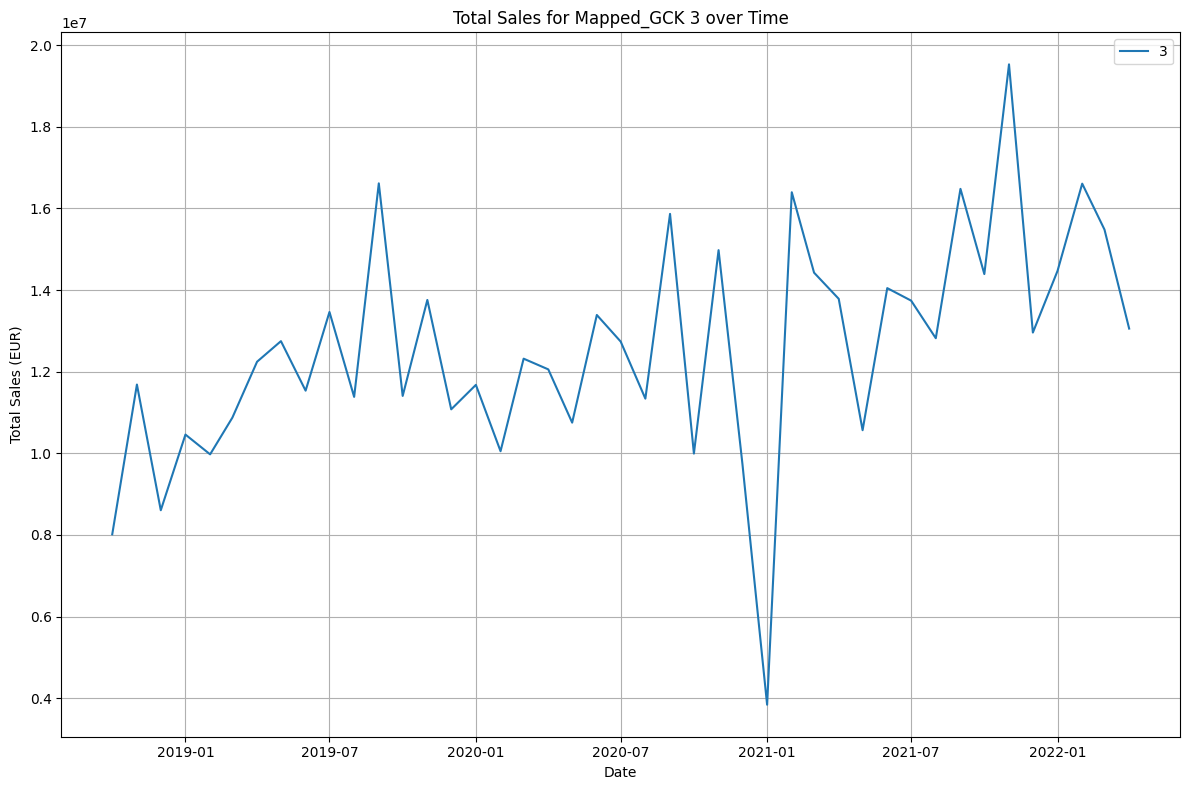

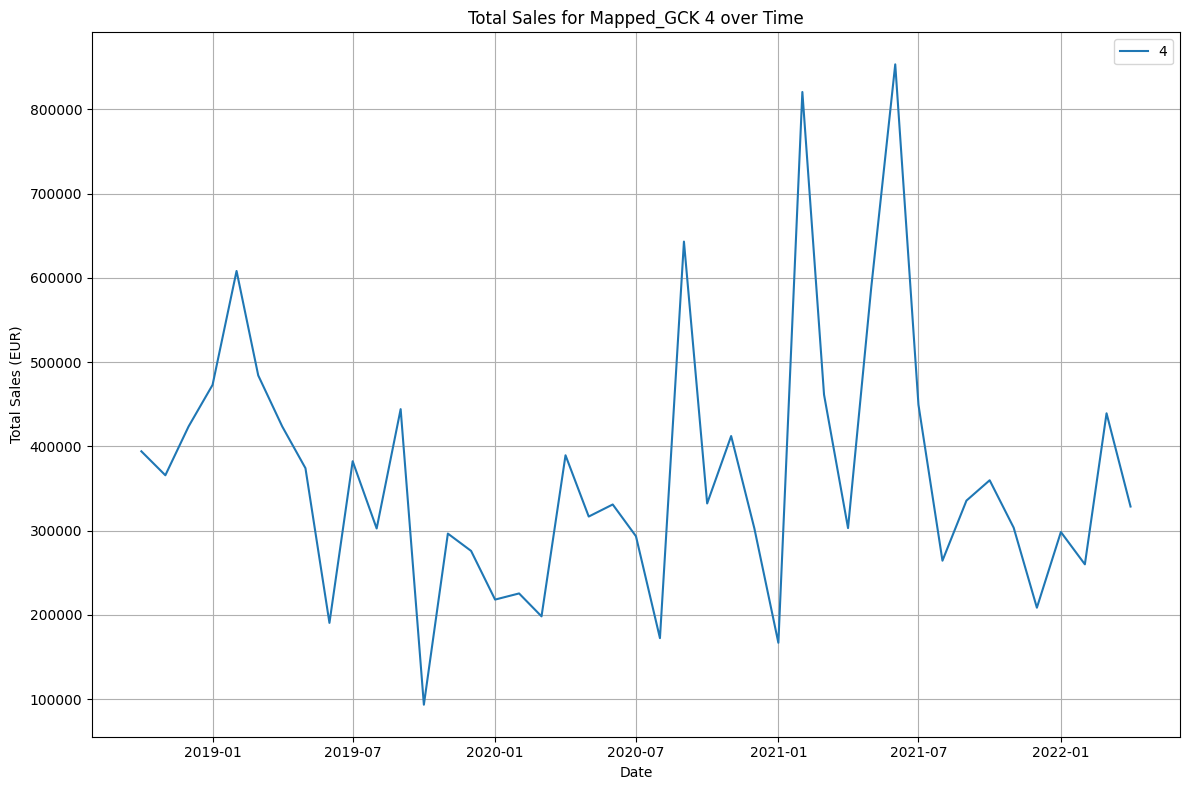

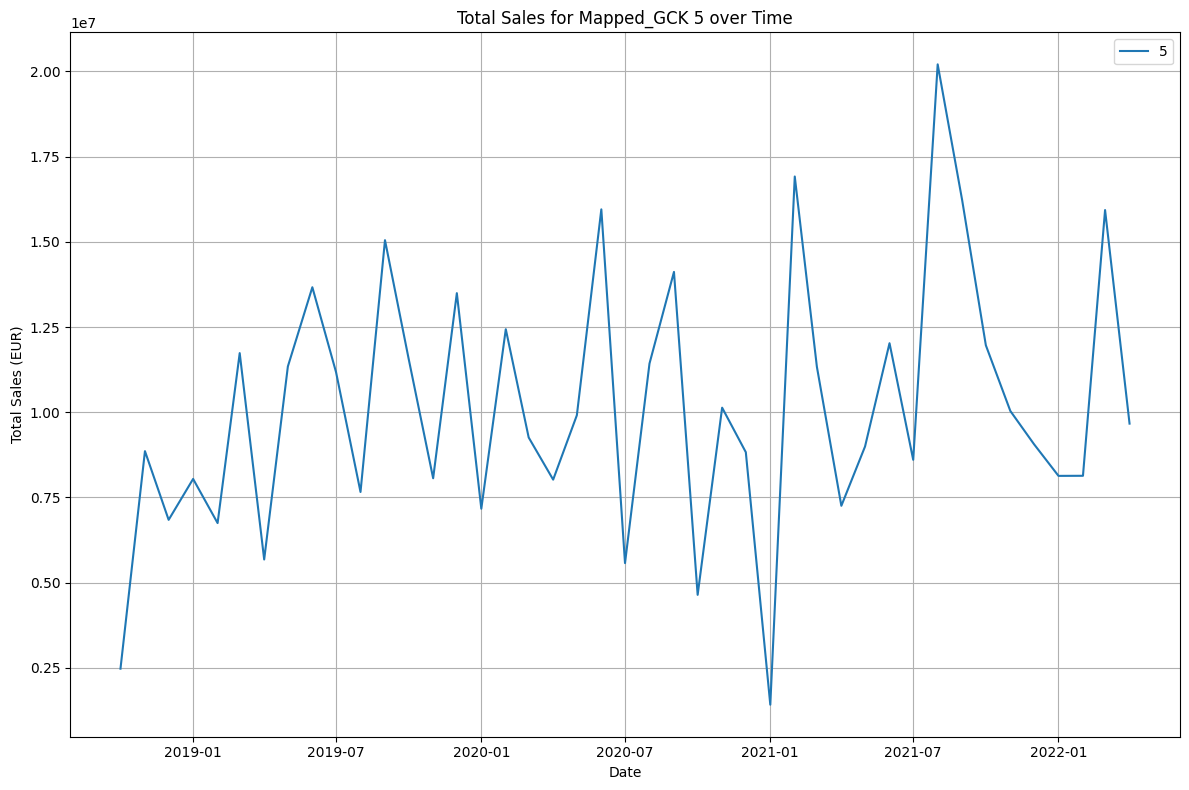

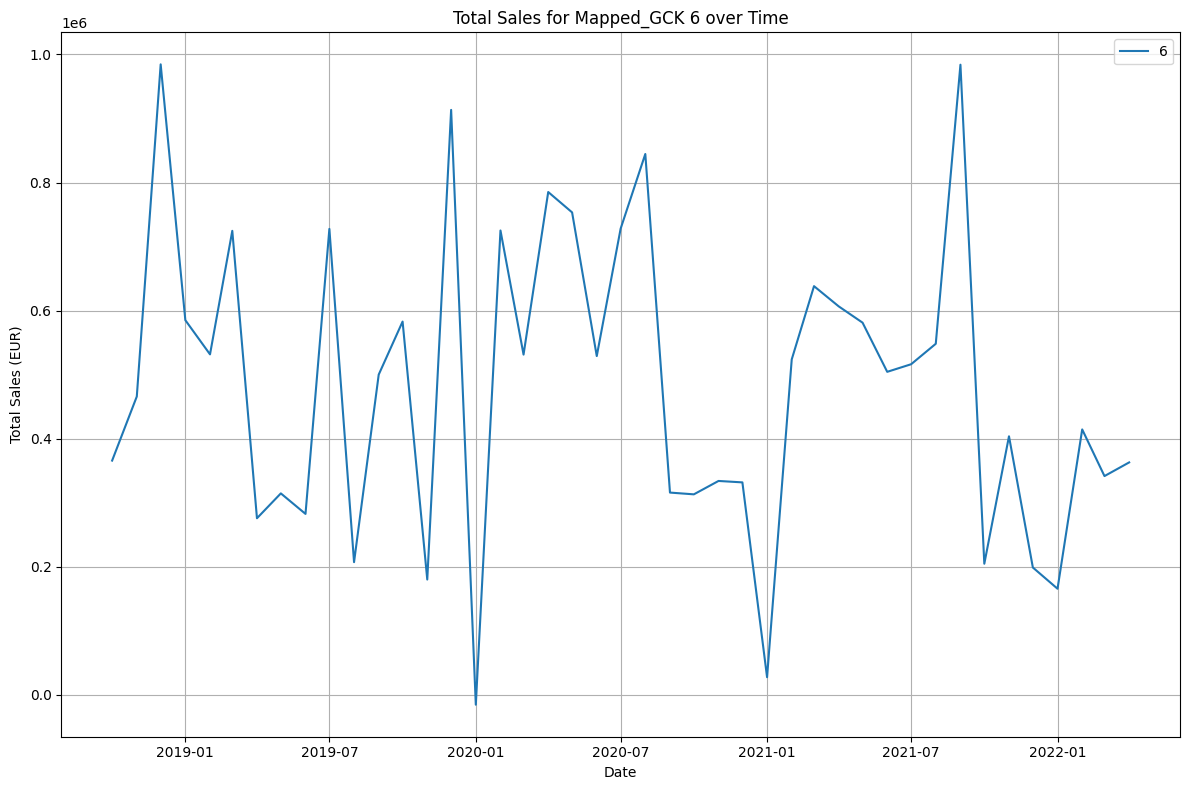

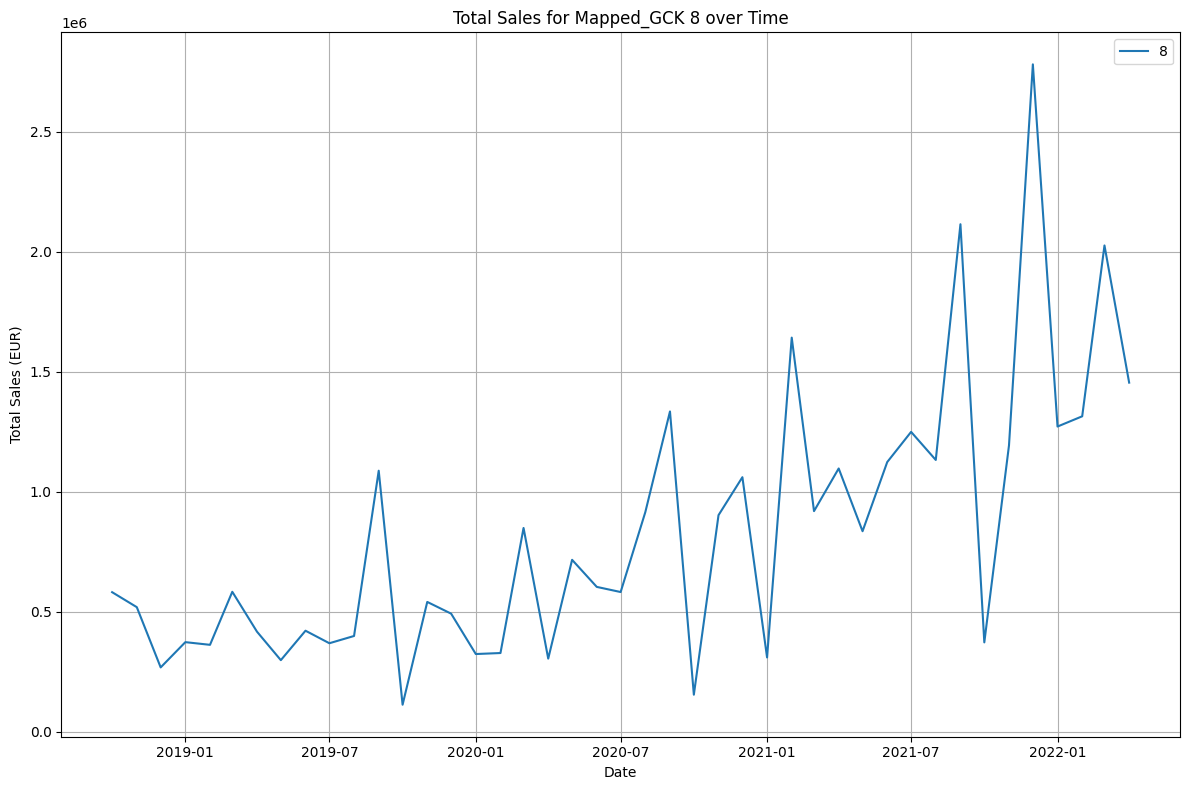

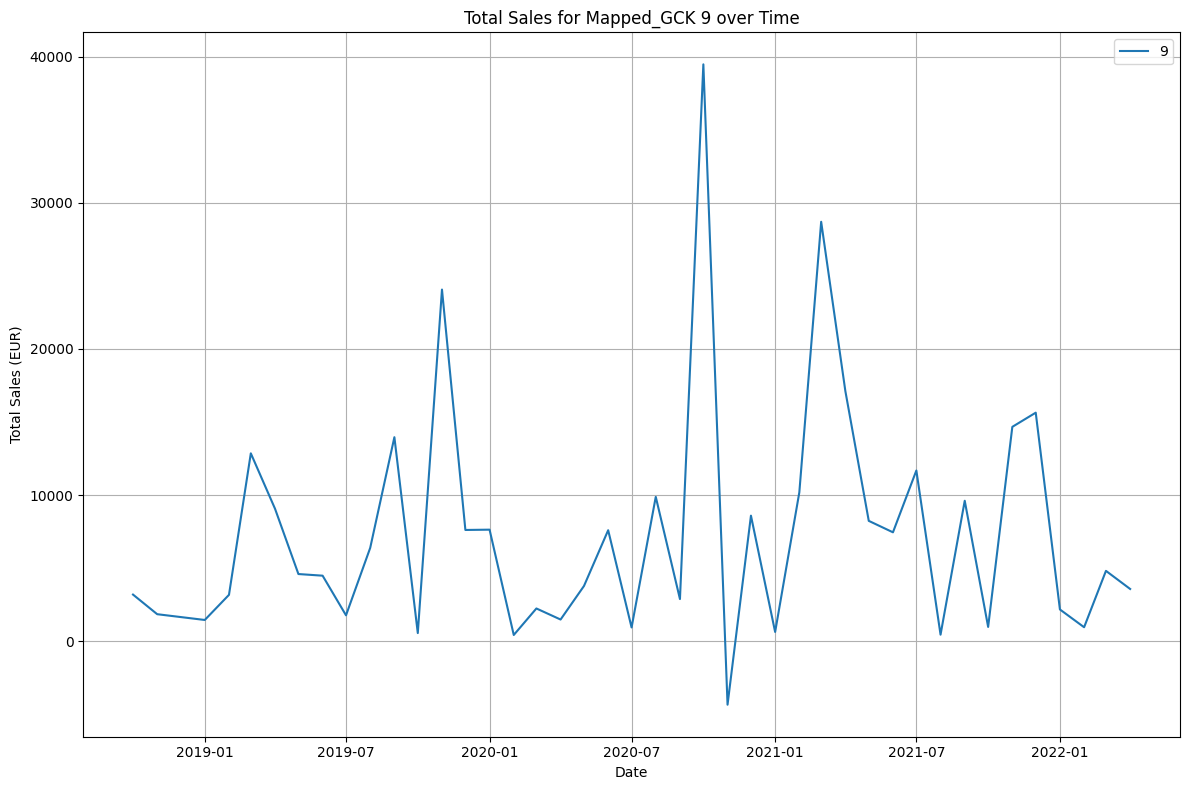

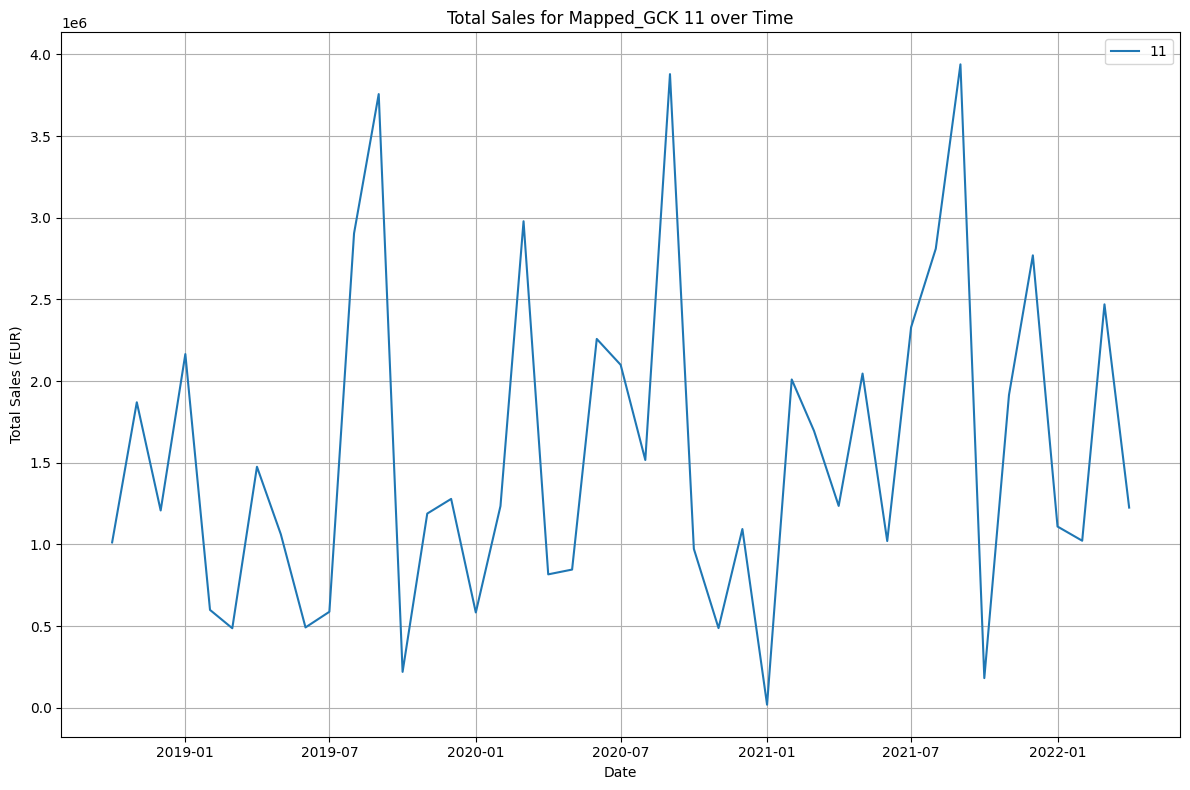

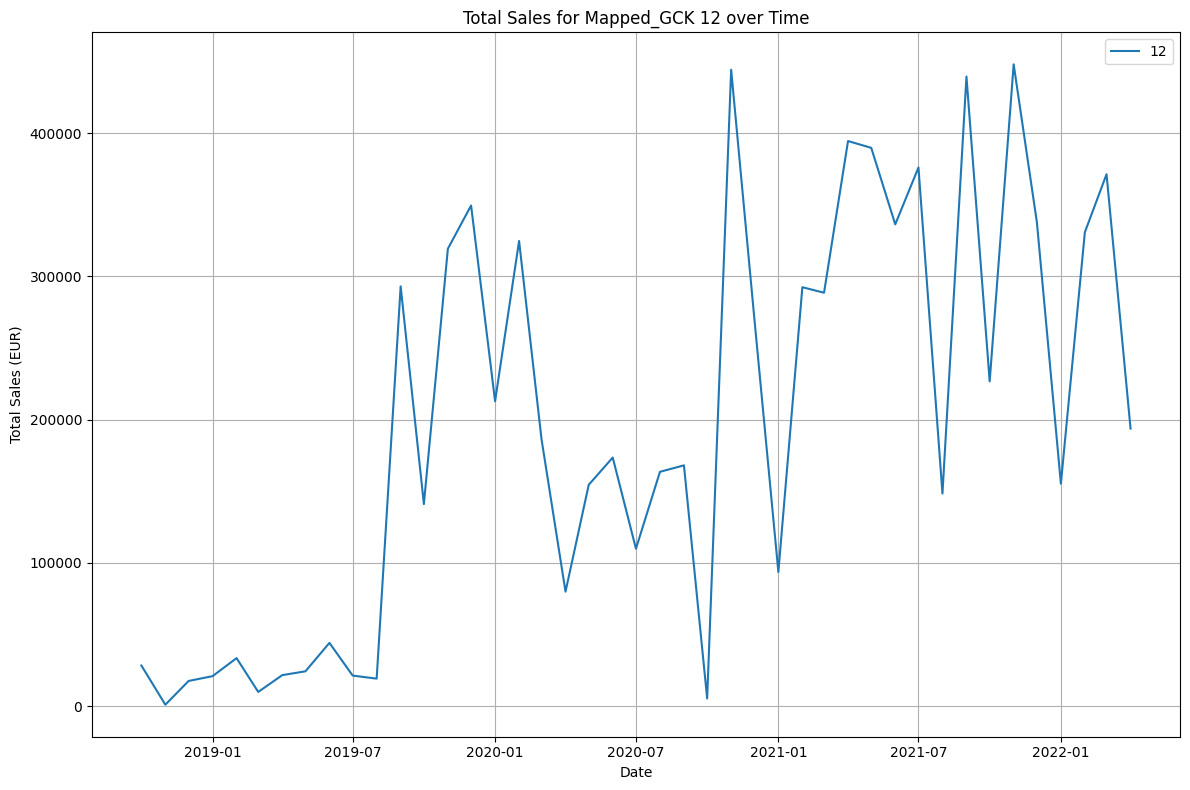

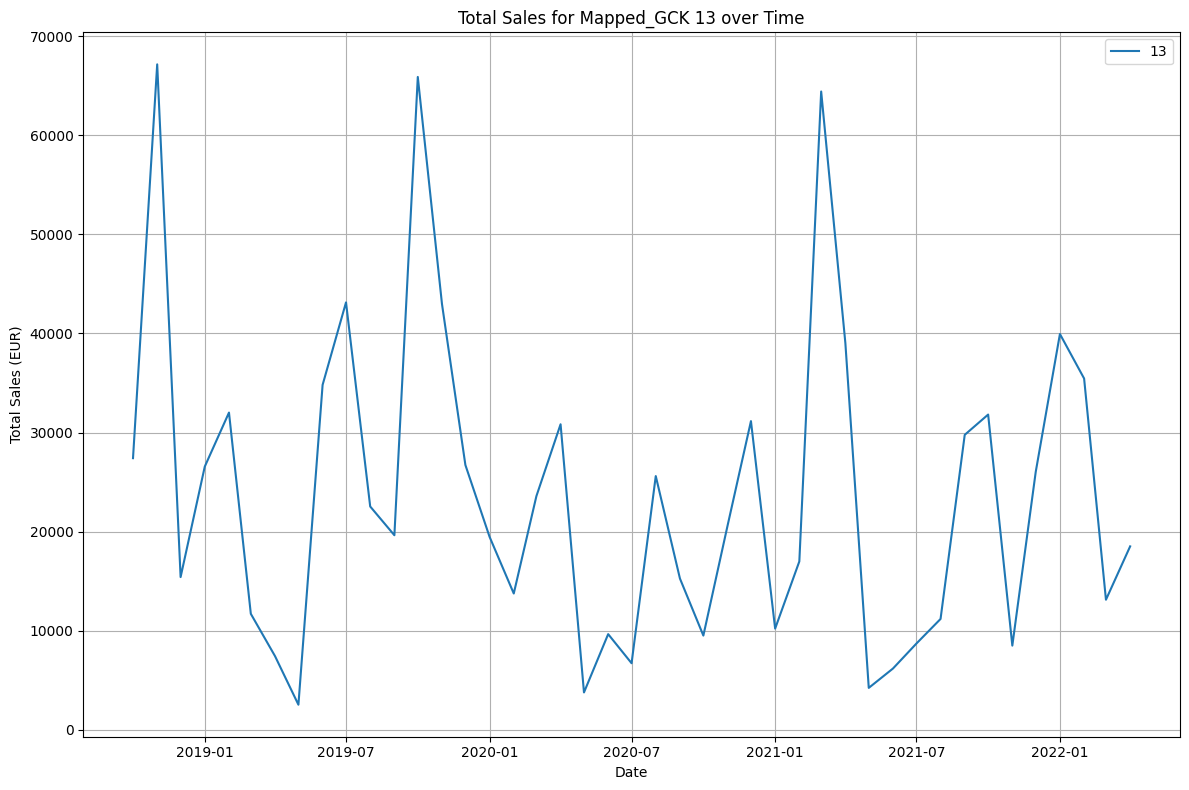

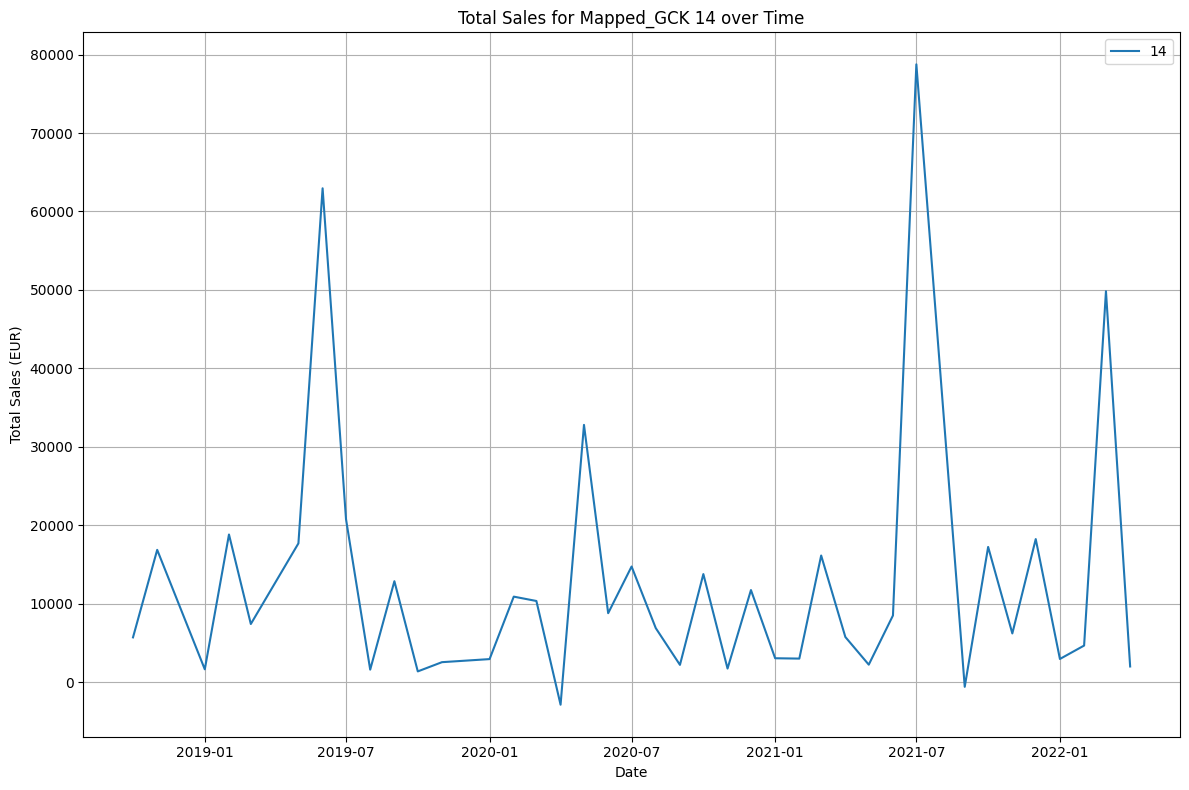

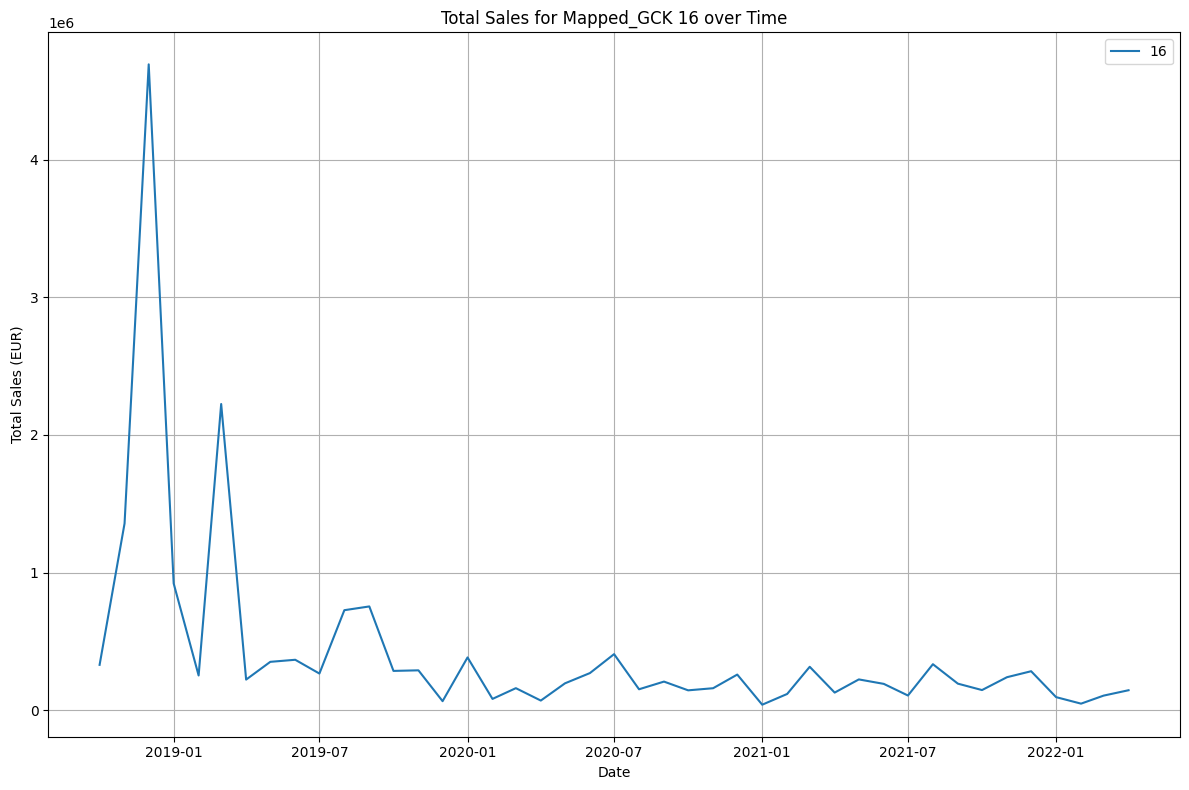

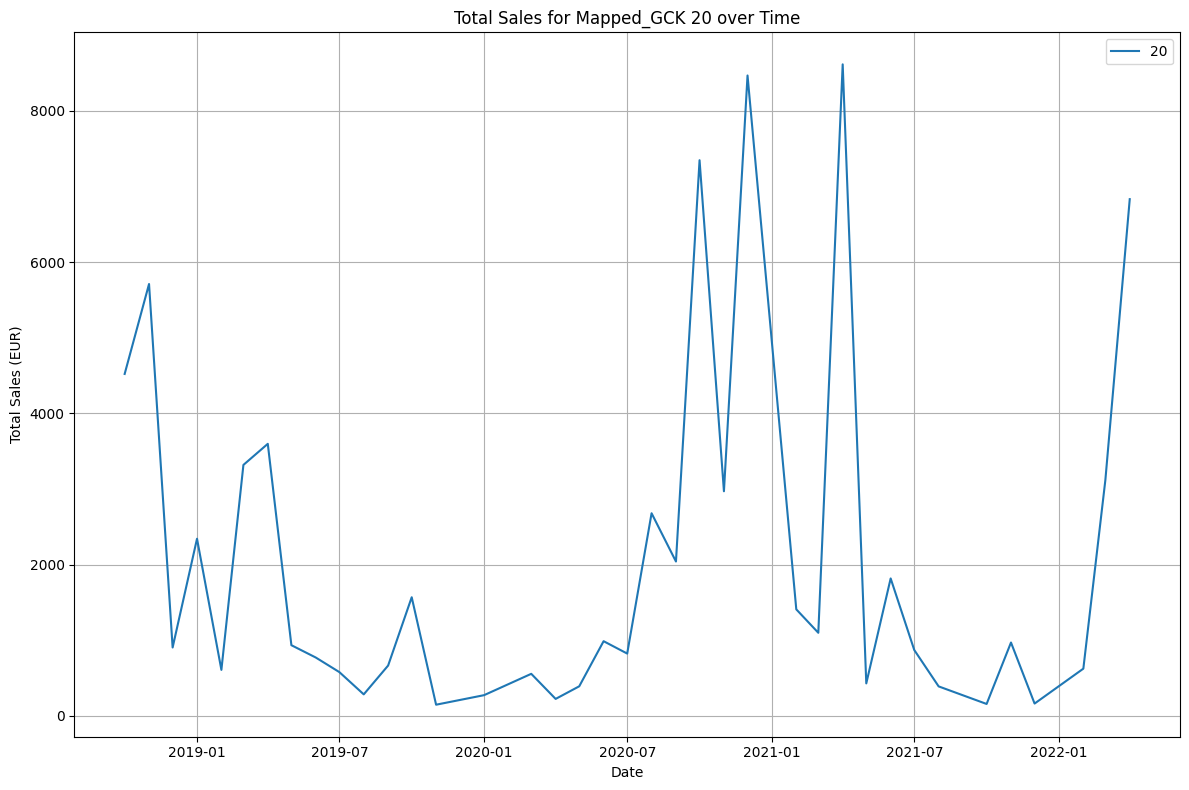

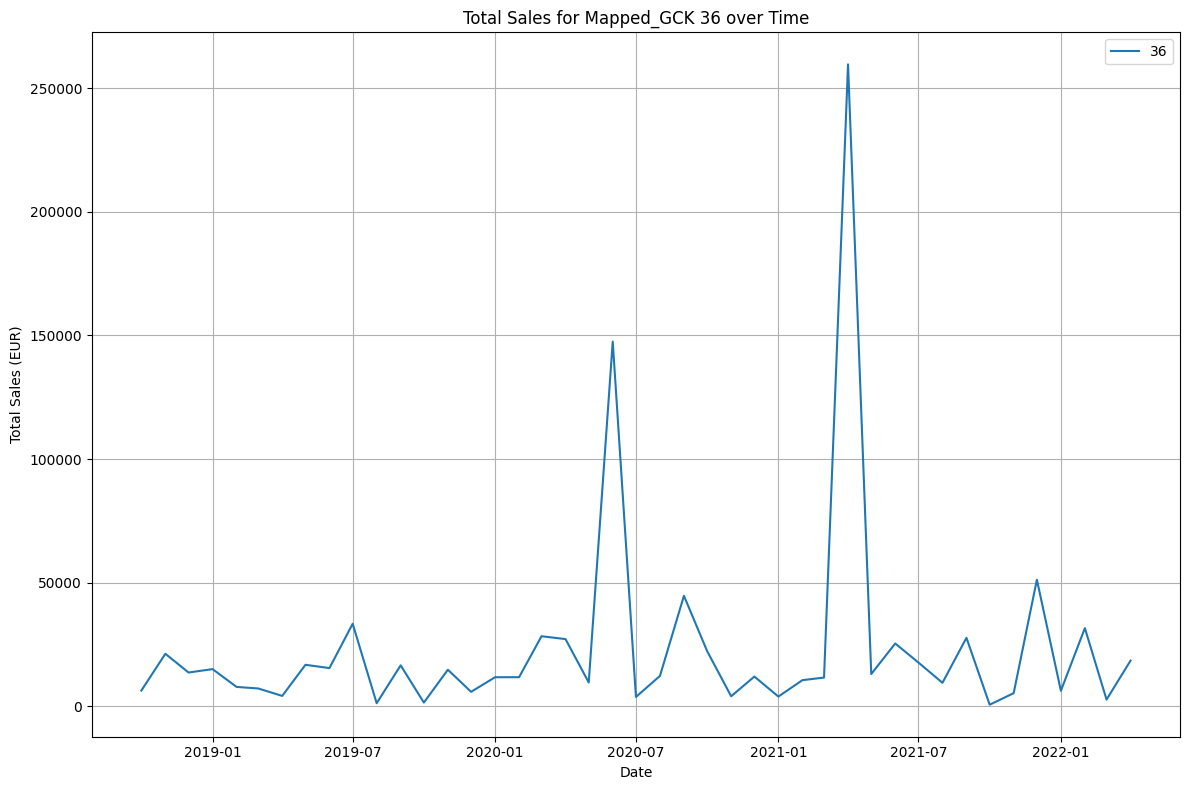

In [107]:
# Group by 'Mapped_GCK' and date, sum 'Sales_EUR' for each group
sales_by_mapped_gck_date = df_feat_eng.groupby(['Mapped_GCK', df_feat_eng['DATE'].dt.date])['Sales_CPI_€'].sum()

# Get unique Mapped_GCK values
unique_mapped_gck = df_feat_eng['Mapped_GCK'].unique()

# Plot the total sales for each 'Mapped_GCK' over time
for mapped_gck in unique_mapped_gck:
    plt.figure(figsize=(12, 8))
    
    # Filter sales data for current Mapped_GCK
    sales_data = sales_by_mapped_gck_date.loc[mapped_gck]
    
    # Plot sales data for the current Mapped_GCK
    plt.plot(sales_data.index, sales_data.values, label=mapped_gck)

    plt.xlabel('Date')
    plt.ylabel('Total Sales (EUR)')
    plt.title(f'Total Sales for Mapped_GCK {mapped_gck} over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Lag Plots

Lag plots are very useful for time series analysis, the resulting plot shows the relationship between the variable and its lagged versions. Its also possible to see if they are stacionary or non-stacionary.
If we see a pattern it is possible for it to be non-stacionary time series, otherwise, they are stacionary

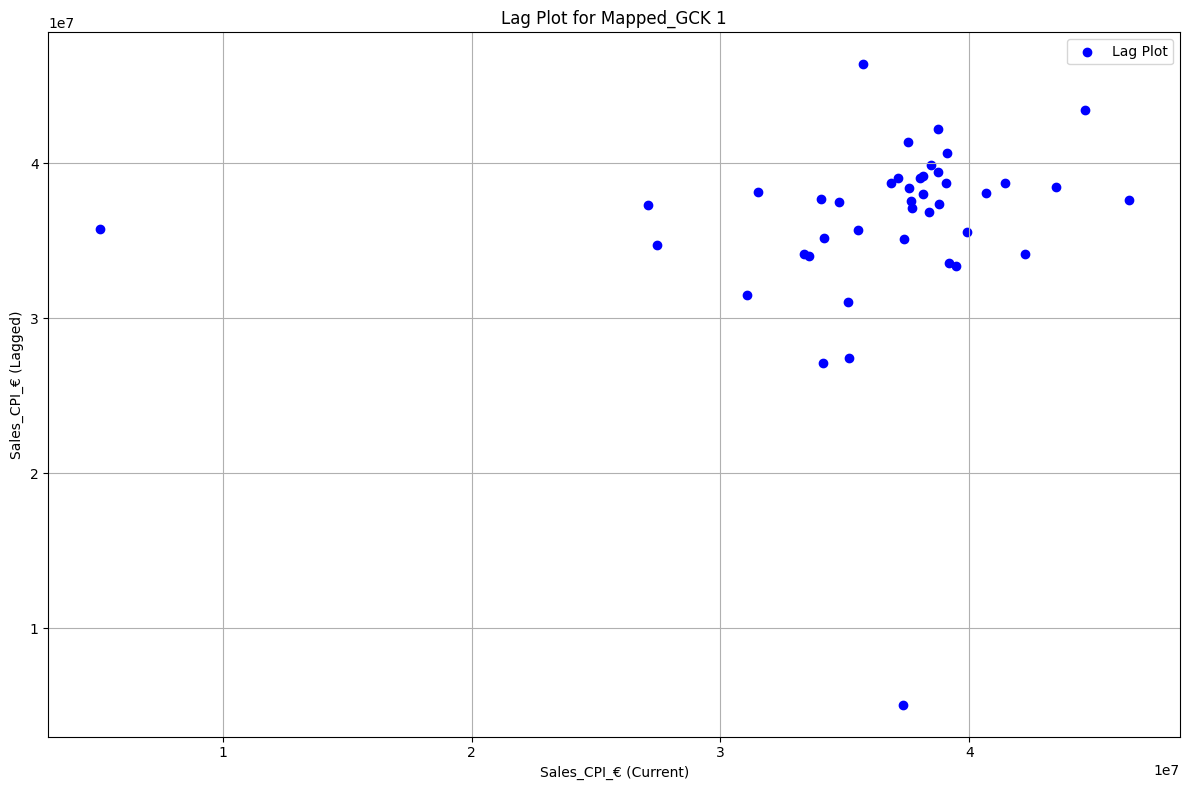

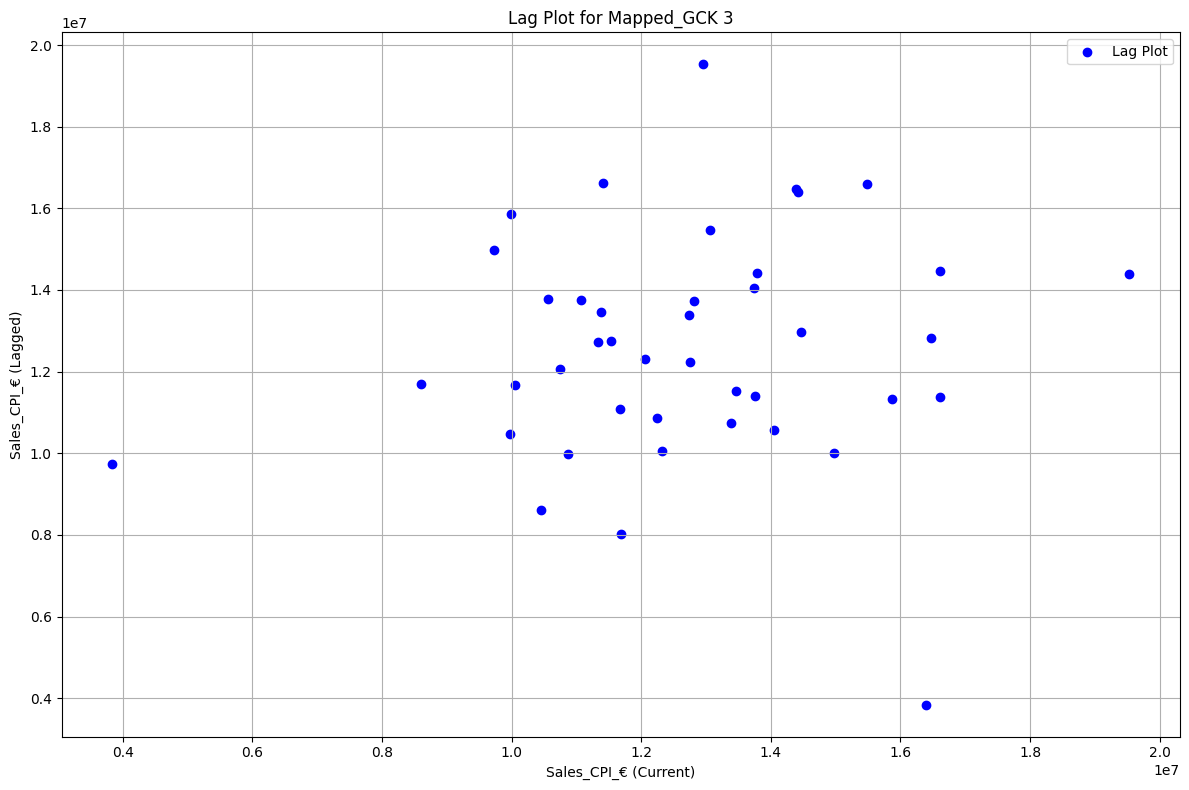

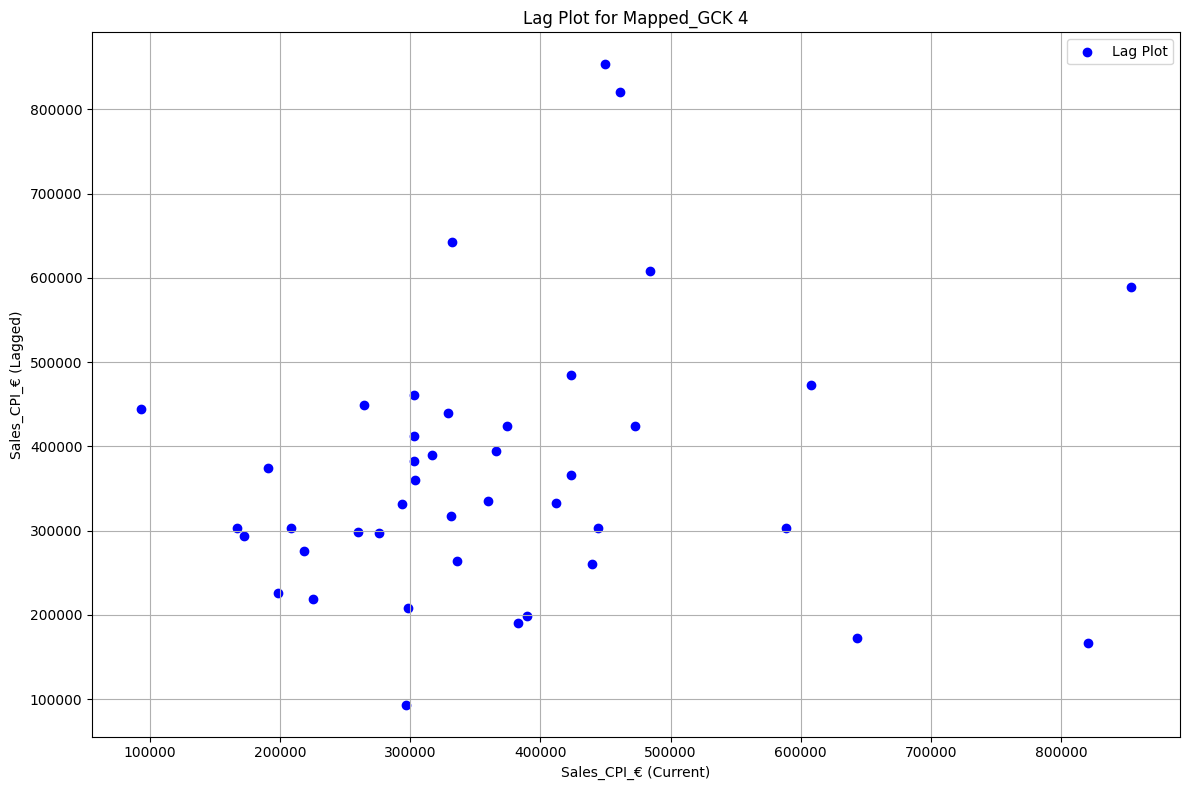

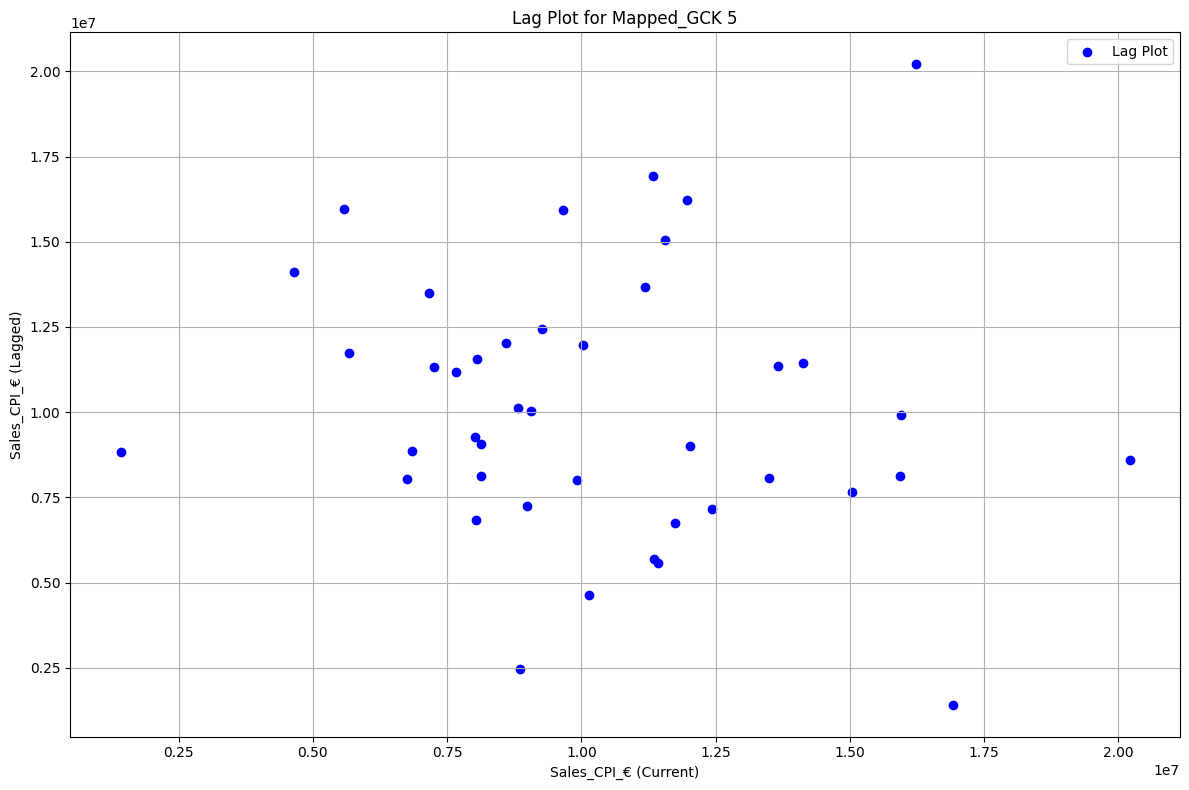

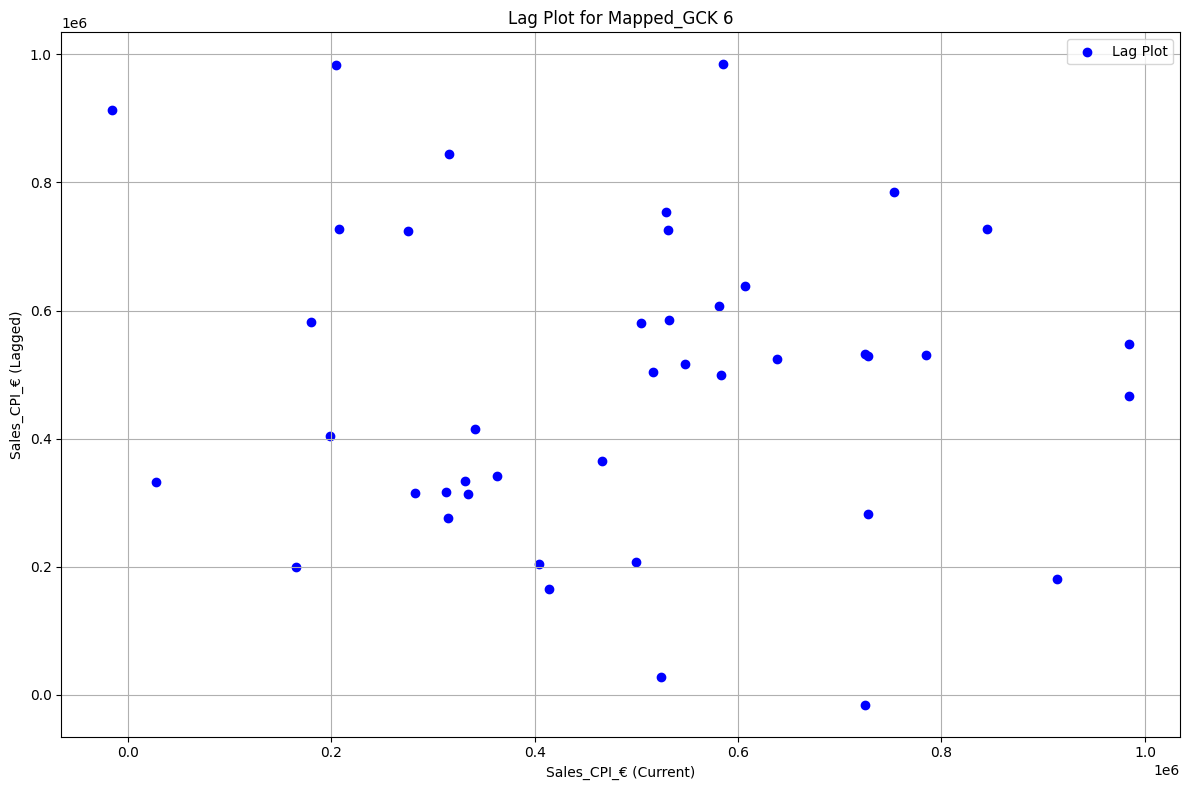

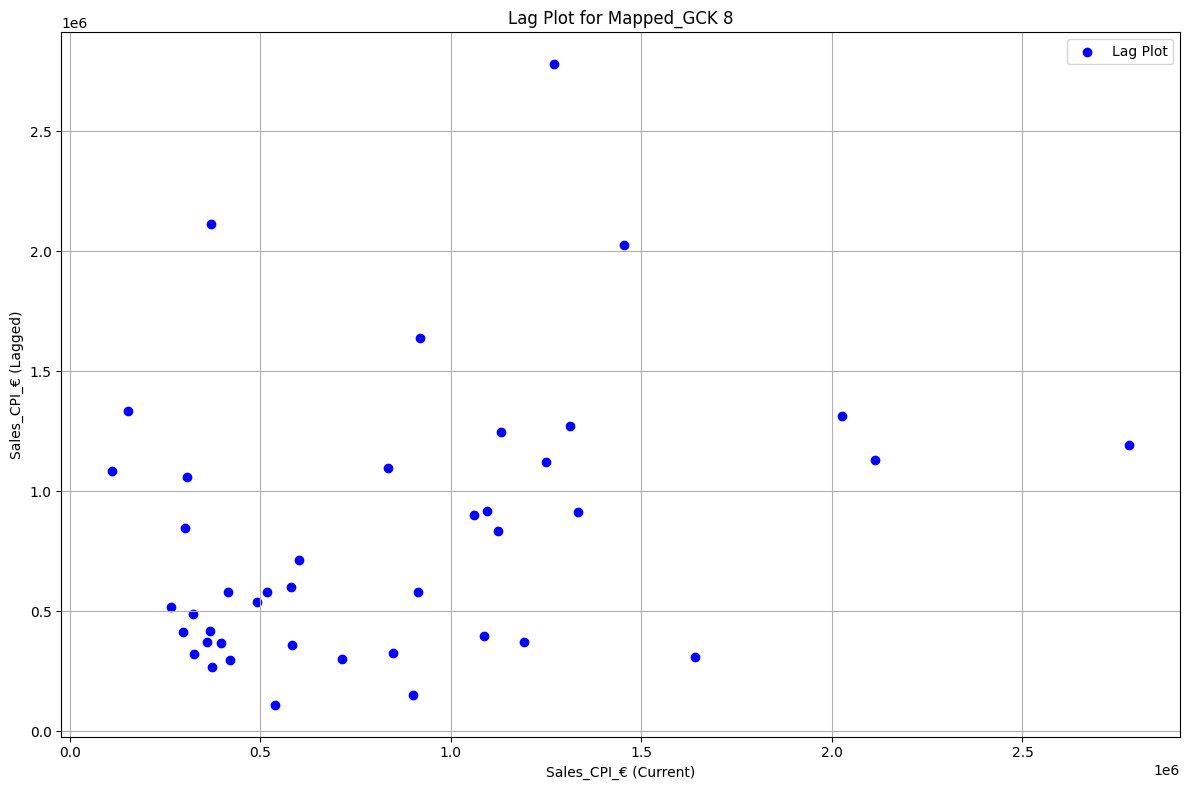

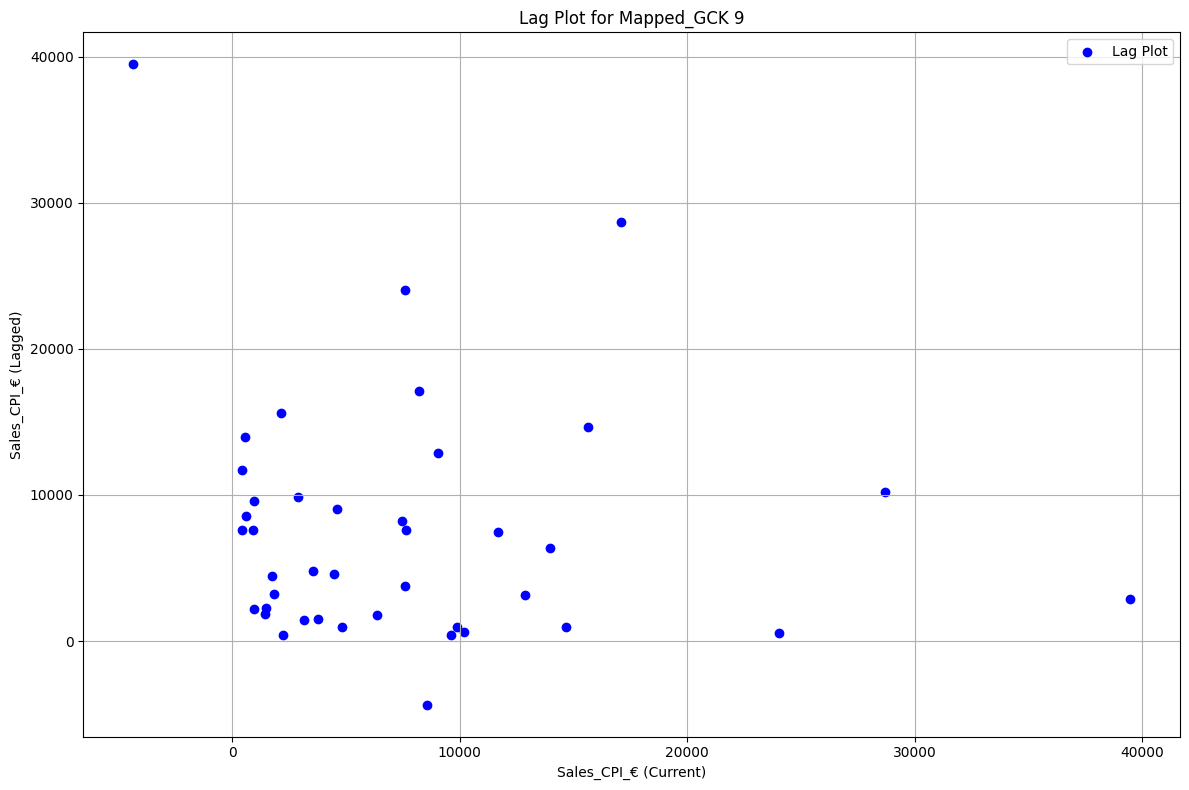

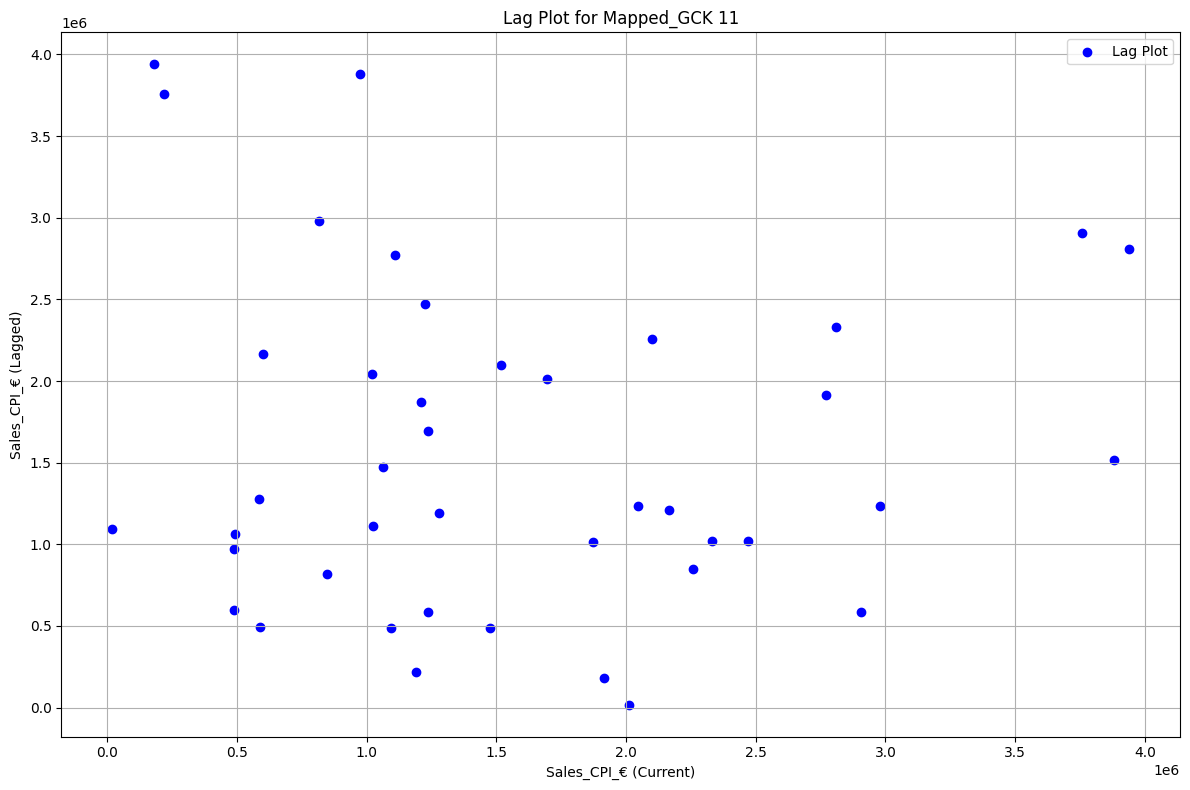

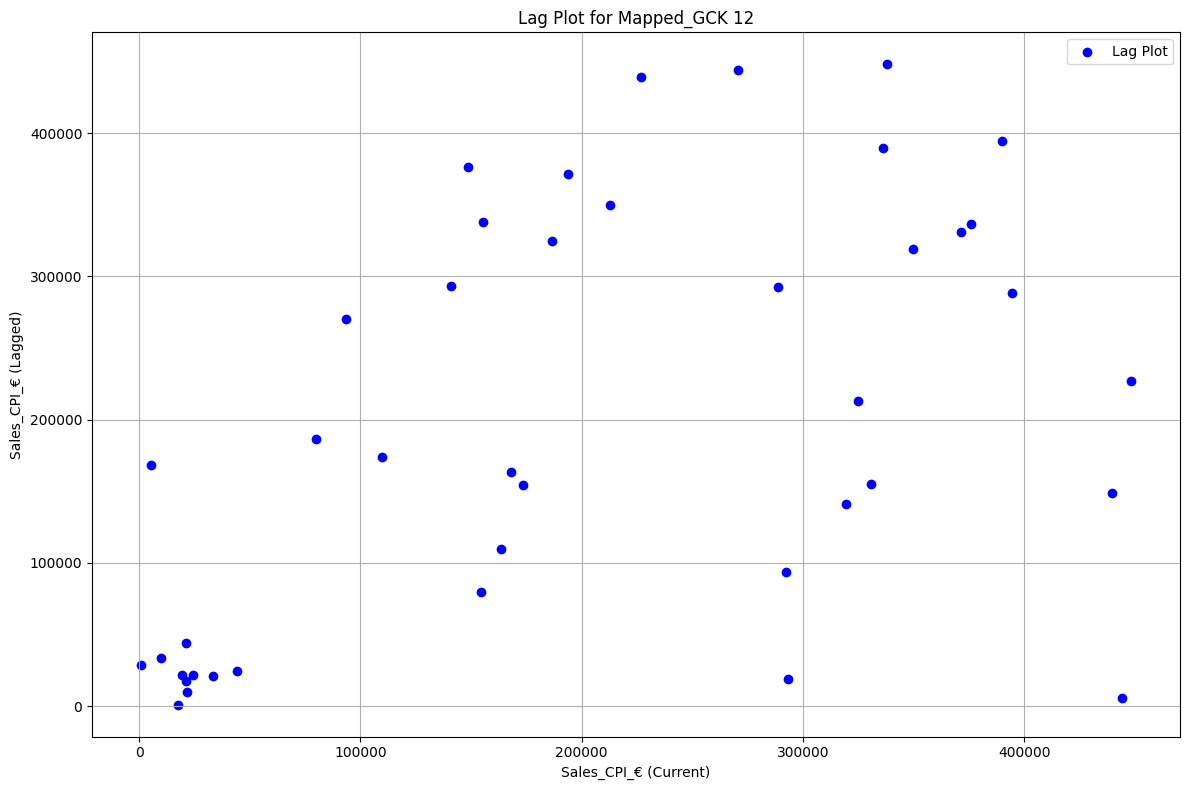

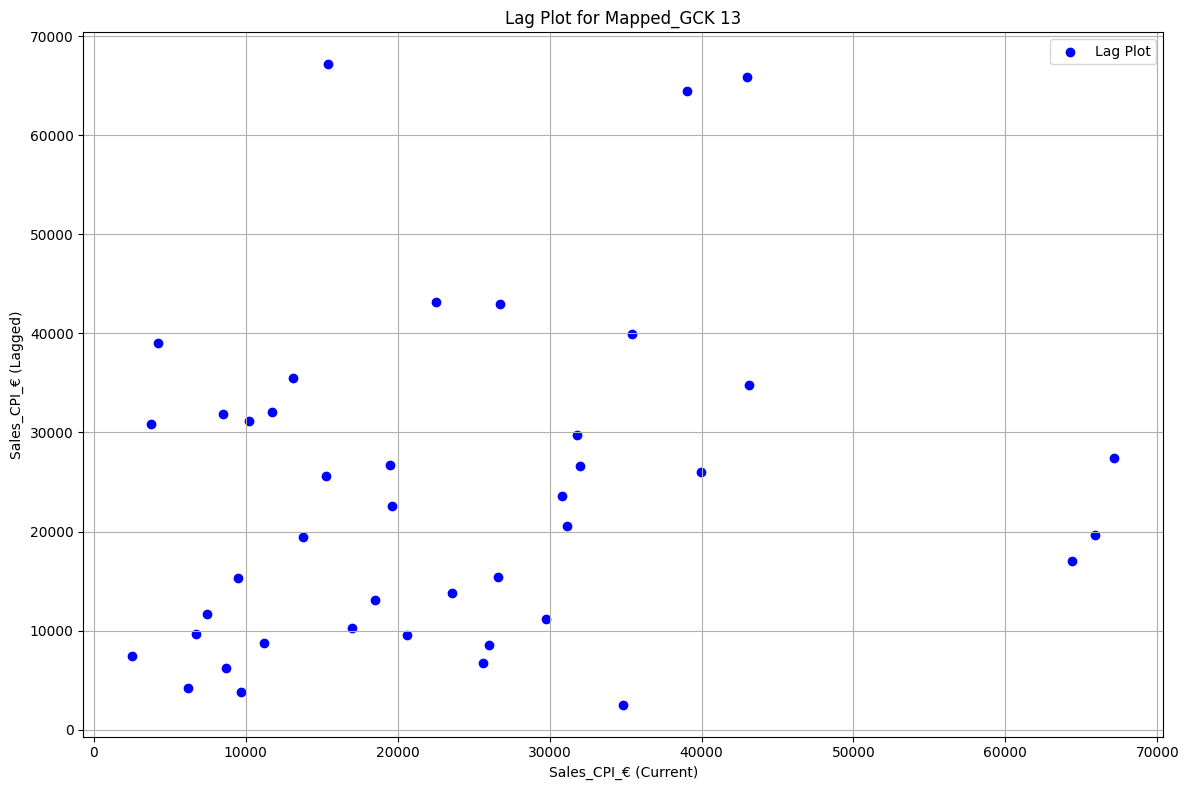

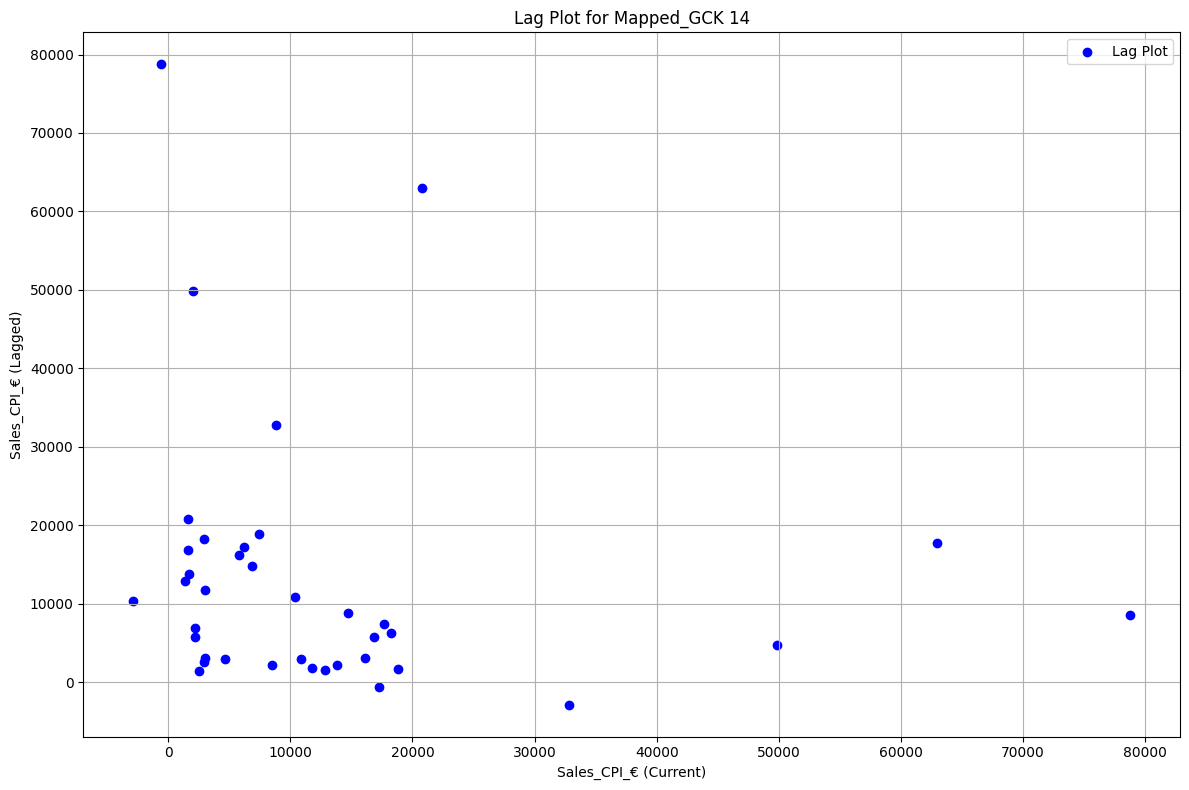

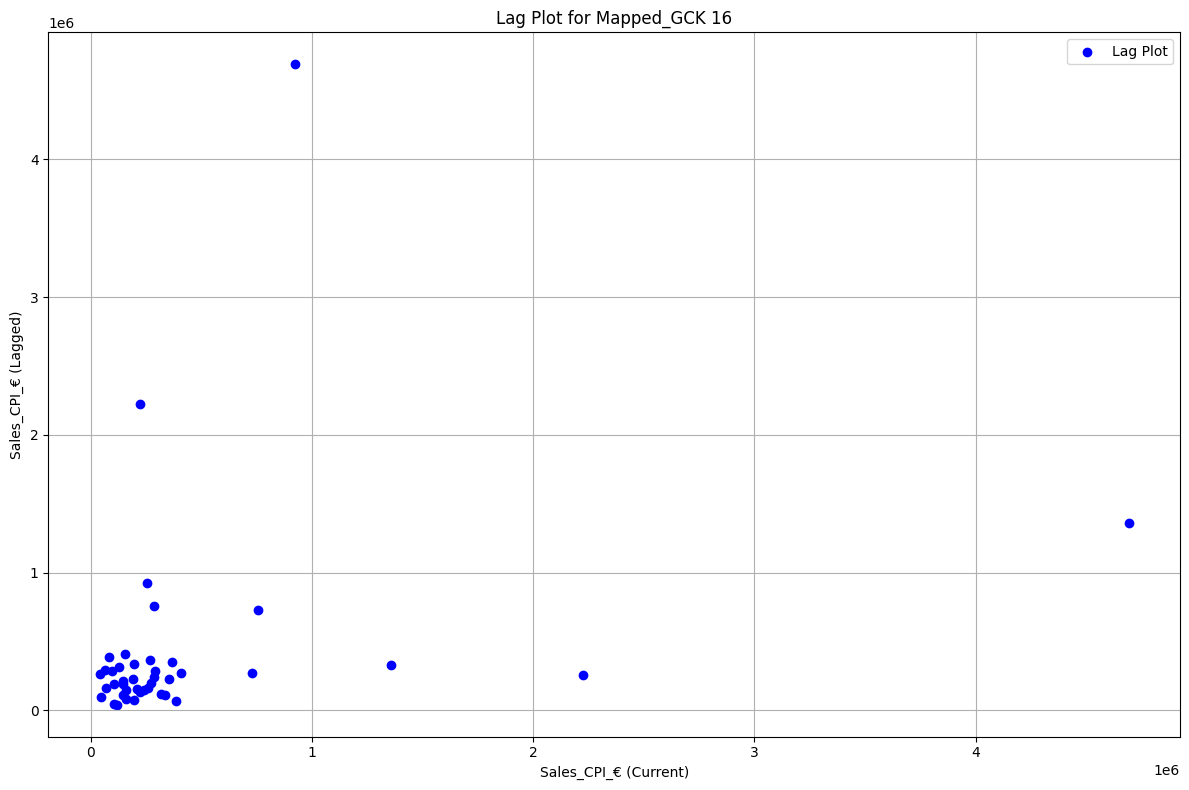

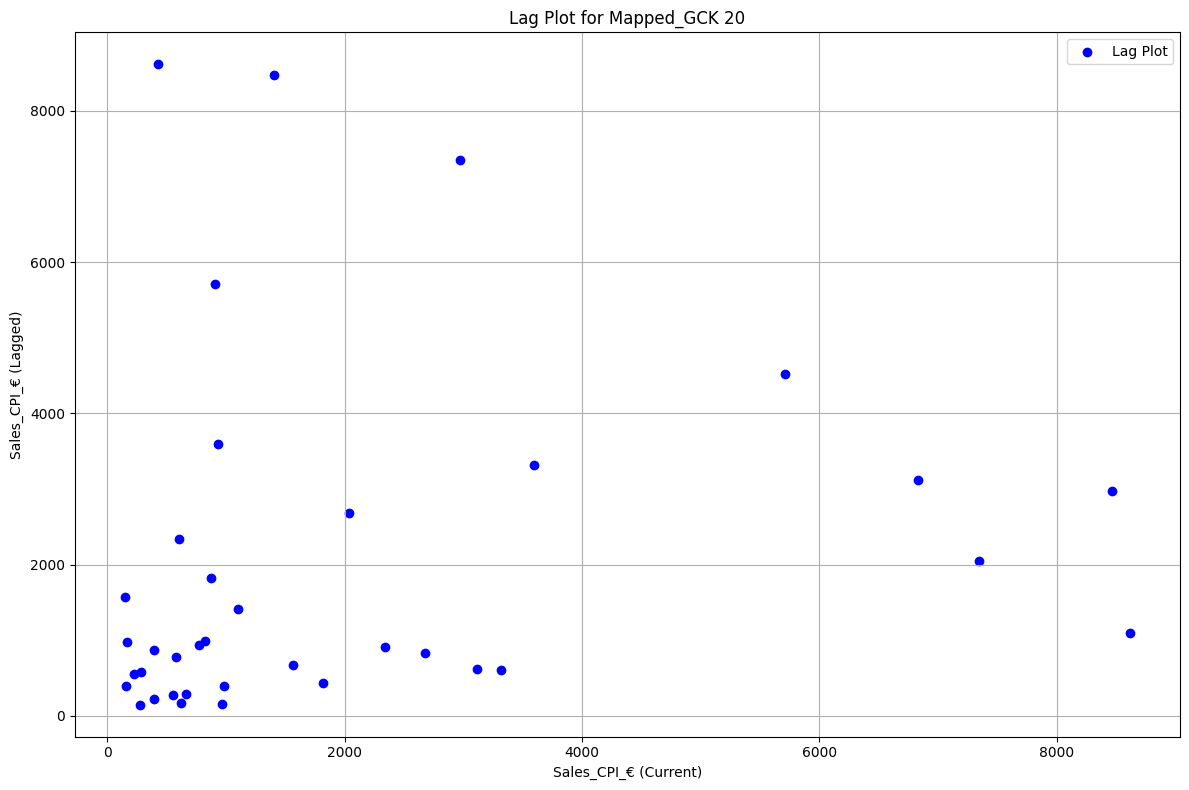

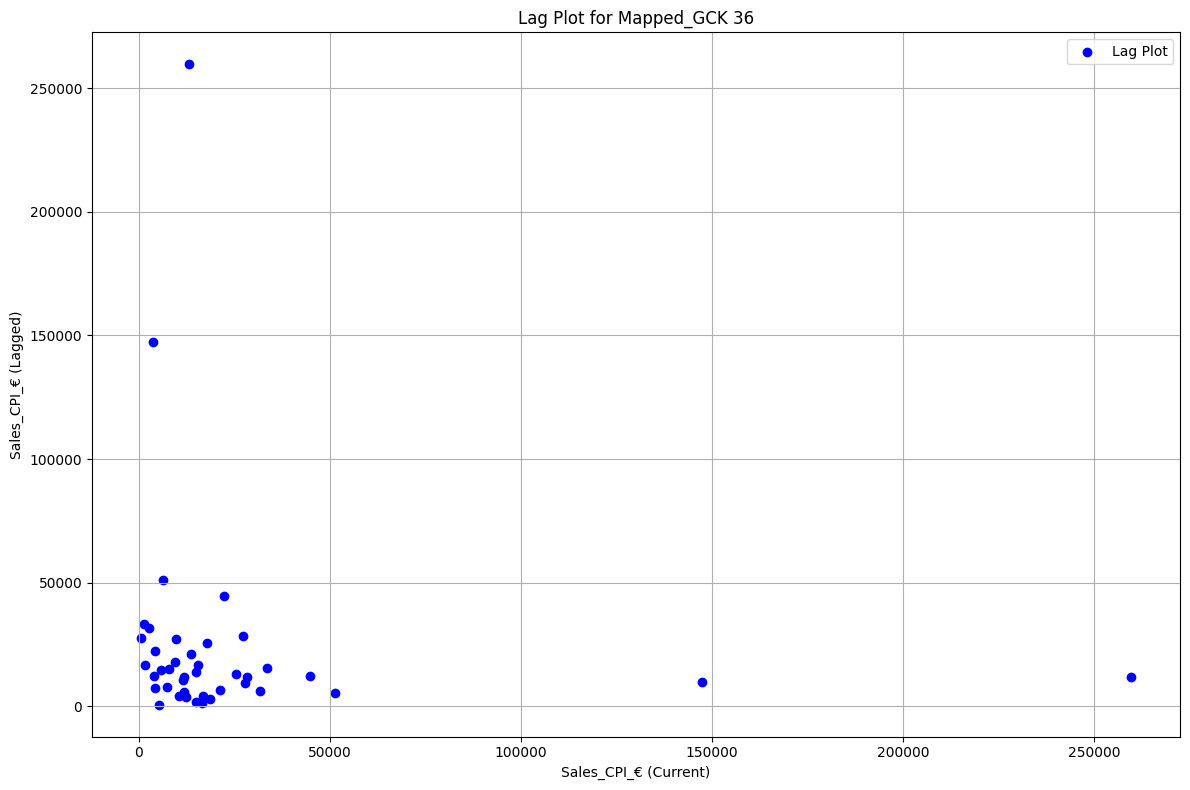

In [108]:
sales_by_mapped_gck_date = df_feat_eng.groupby(['Mapped_GCK', df_feat_eng['DATE'].dt.date])['Sales_CPI_€'].sum()

# Get unique Mapped_GCK values
unique_mapped_gck = df_feat_eng['Mapped_GCK'].unique()

# Plot lag plots for each 'Mapped_GCK'
for mapped_gck in unique_mapped_gck:
    plt.figure(figsize=(12, 8))
    
    # Filter sales data for current Mapped_GCK
    sales_data = sales_by_mapped_gck_date.loc[mapped_gck]
    
    # Calculate lagged values
    sales_lagged = sales_data.shift(1)  # You can adjust the lag value as needed
    
    # Plot sales data against lagged values
    plt.scatter(sales_data, sales_lagged, label='Lag Plot', color='blue')
    
    plt.xlabel('Sales_CPI_€ (Current)')
    plt.ylabel('Sales_CPI_€ (Lagged)')
    plt.title(f'Lag Plot for Mapped_GCK {mapped_gck}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

From the above visualizations it seems that the different Group Products are stationary (no pattern can be seen straight-away).

Perform the **ADF test** to have a better precision on saying if they are stacionary or non stacionary for each CGK.

In [109]:
# Group by 'Mapped_GCK' and date, sum 'Sales_CPI_€' for each group
sales_by_mapped_gck_date = df_feat_eng.groupby(['Mapped_GCK', df_feat_eng['DATE'].dt.date])['Sales_CPI_€'].sum()

# Get unique Mapped_GCK values
unique_mapped_gck = df_feat_eng['Mapped_GCK'].unique()

# Perform ADF test for each 'Mapped_GCK' category
for mapped_gck in unique_mapped_gck:
    # Filter sales data for current Mapped_GCK
    sales_data = sales_by_mapped_gck_date.loc[mapped_gck]
    
    # Perform the Augmented Dickey-Fuller test
    adf_test_result = adfuller(sales_data)
    
    # Extract the p-value from the test result
    p_value = adf_test_result[1]
    
    # Determine stationarity based on the p-value
    if p_value < 0.05:
        print(f"The time series for Mapped_GCK '{mapped_gck}' is stationary (p-value: {p_value})")
    else:
        print(f"The time series for Mapped_GCK '{mapped_gck}' is non-stationary (p-value: {p_value})")


The time series for Mapped_GCK '1' is stationary (p-value: 3.063394316395665e-06)
The time series for Mapped_GCK '3' is stationary (p-value: 2.4833729764064977e-07)
The time series for Mapped_GCK '4' is stationary (p-value: 4.374404442735414e-06)
The time series for Mapped_GCK '5' is stationary (p-value: 9.052443680308147e-11)
The time series for Mapped_GCK '6' is stationary (p-value: 0.006319111024141623)
The time series for Mapped_GCK '8' is non-stationary (p-value: 0.9990876937986093)
The time series for Mapped_GCK '9' is stationary (p-value: 6.379707594171069e-10)
The time series for Mapped_GCK '11' is stationary (p-value: 2.247644836986048e-06)
The time series for Mapped_GCK '12' is stationary (p-value: 0.0028083893832133396)
The time series for Mapped_GCK '13' is stationary (p-value: 0.01608998198613349)
The time series for Mapped_GCK '14' is stationary (p-value: 1.3265804706078694e-09)
The time series for Mapped_GCK '16' is stationary (p-value: 3.1078951214880464e-08)
The time s

For the non-stacionary one, Mapped_CGK = 8, we are gonna look deep into the data to get insights about trends and sazonality

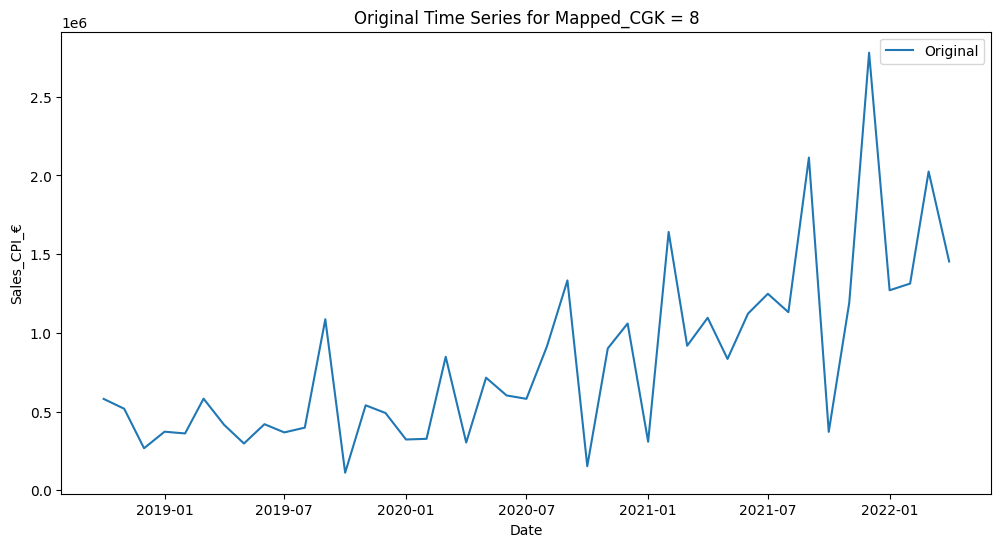

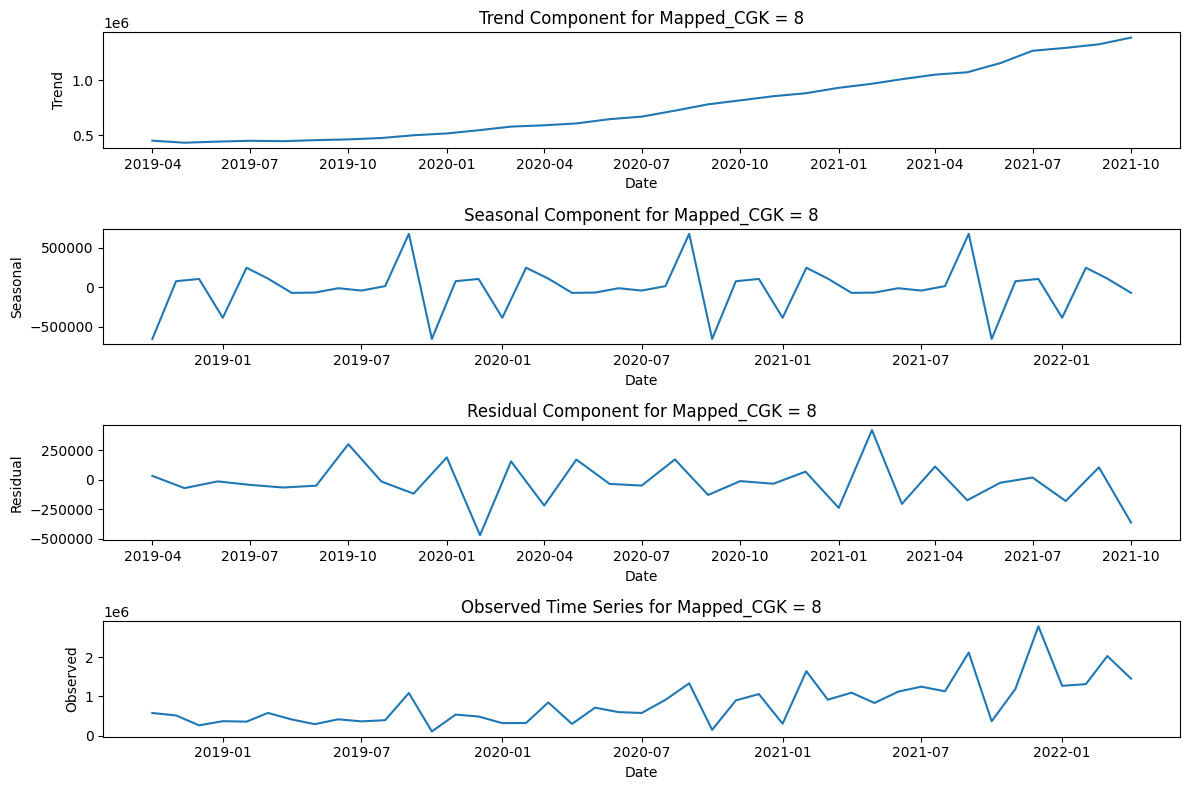

In [110]:
sales_data_mapped_cgk_8 = sales_by_mapped_gck_date.loc[8]

# Plot the original time series
plt.figure(figsize=(12, 6))
plt.plot(sales_data_mapped_cgk_8.index, sales_data_mapped_cgk_8.values, label='Original')
plt.xlabel('Date')
plt.ylabel('Sales_CPI_€')
plt.title('Original Time Series for Mapped_CGK = 8')
plt.legend()
plt.show()

# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(sales_data_mapped_cgk_8, model='additive', period=12)  # Assuming seasonality of period 12 (monthly data)

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(decomposition.trend.index, decomposition.trend.values, label='Trend')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.title('Trend Component for Mapped_CGK = 8')

plt.subplot(412)
plt.plot(decomposition.seasonal.index, decomposition.seasonal.values, label='Seasonal')
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.title('Seasonal Component for Mapped_CGK = 8')

plt.subplot(413)
plt.plot(decomposition.resid.index, decomposition.resid.values, label='Residual')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Residual Component for Mapped_CGK = 8')

plt.subplot(414)
plt.plot(decomposition.observed.index, decomposition.observed.values, label='Observed')
plt.xlabel('Date')
plt.ylabel('Observed')
plt.title('Observed Time Series for Mapped_CGK = 8')

plt.tight_layout()
plt.show()


There is clearly a sazonality in this product

# Export df

In [36]:
df_feat_eng.to_excel('sales_updated.xlsx', index=False)